In [2]:
import pyabf 


abf = pyabf.ABF("data/2025_12_04_0001.abf")  # load the file
abf.setSweep(0,channel= 0)  # Channel 0 is recording channel
spike_ch = abf.sweepY.copy()
time_vec = abf.sweepX.copy()

abf.setSweep(0,channel= 2)  # Channel 2 is Stim channel
stim_ch = abf.sweepY.copy()
stim_ch_m = max(stim_ch)
stim_ch = (stim_ch-stim_ch_m)*-1


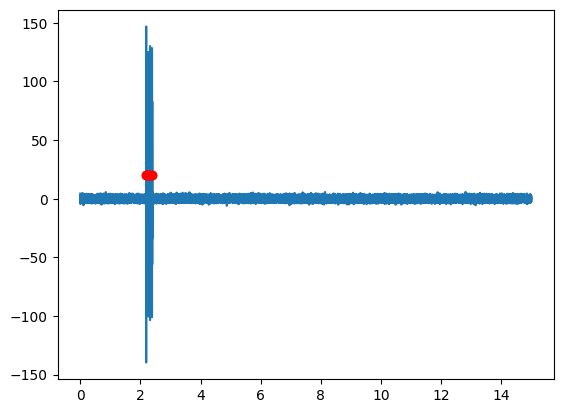

(np.float64(2.2), np.float64(2.5), np.float64(-150.0), np.float64(150.0))

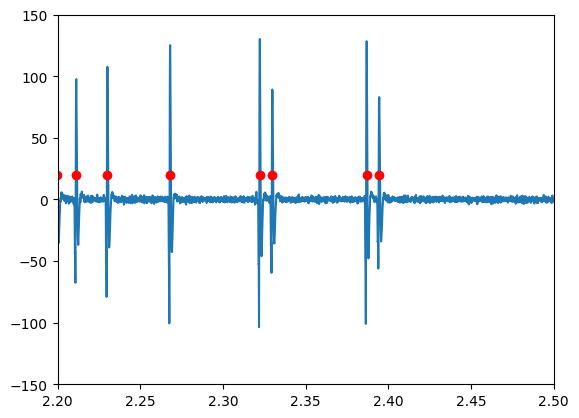

In [1]:
import pyabf 


abf = pyabf.ABF("data/2026_01_14_0007.abf")  # load the file
abf.setSweep(0,channel= 0)  # Channel 0 is recording channel
spike_ch = abf.sweepY.copy()
time_vec = abf.sweepX.copy()

abf.setSweep(0,channel= 2)  # Channel 2 is Stim channel
stim_ch = abf.sweepY.copy()
stim_ch_m = max(stim_ch)
stim_ch = (stim_ch-stim_ch_m)*-1

from scipy.signal import find_peaks
import matplotlib.pyplot as plt
peaks, _ = find_peaks(spike_ch, height = 20)
plt.plot(time_vec,spike_ch)
plt.plot(peaks/2e4,[20]*len(peaks),'o',c = 'red')
# plt.axis([0, 16, -60, 60])
plt.show()


plt.plot(time_vec,spike_ch)
plt.plot(peaks/2e4,[20]*len(peaks),'o',c = 'red')
plt.axis([2.2, 2.5, -150, 150])

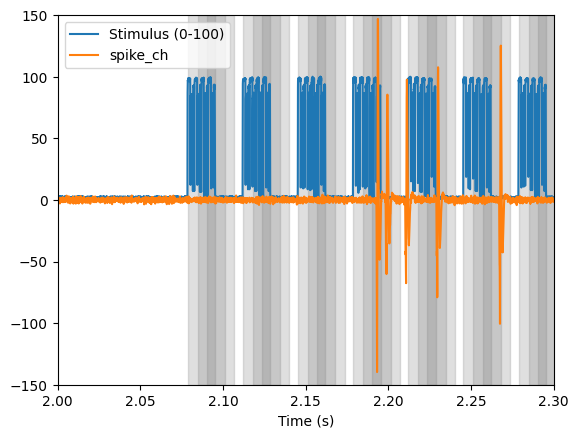

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from Neitz import Neitz  # (or from Neitz import Neitz if you didn't rename)

PULSES_PER_BURST = 4
FRAME_S = 1/60

laser = Neitz(filepath=Path.cwd())
laser.abfread("2026_01_14_0007.abf")

# flip + normalize stim to 0..100 (as you did)
laser.stim_ch = -laser.stim_ch
laser.stim_ch = laser.stim_ch - laser.stim_ch.min()
laser.stim_ch = laser.stim_ch / laser.stim_ch.max() * 100

# ---- gray square logic (on laser.stim_ch) ----
thr = 50  # threshold in 0..100 space
stim_on = laser.stim_ch > thr
rise = np.where(np.diff(stim_on.astype(int)) == 1)[0] + 1

anchor_idx = rise[::PULSES_PER_BURST]
anchor_t = laser.time_vec[anchor_idx]

# ---- plot ----
plt.figure()
plt.plot(laser.time_vec, laser.stim_ch, label="Stimulus (0-100)")
plt.plot(laser.time_vec, laser.spike_ch, label="spike_ch")
plt.plot(laser.time_vec[laser.peaks], laser.spike_ch[laser.peaks], "o", c="red", label="spikes") \
    if hasattr(laser, "peaks") else None

for t0 in anchor_t:
    plt.axvspan(t0, t0 + FRAME_S, color="grey", alpha=0.25)

plt.axis([2, 2.3, -150, 150])
plt.xlabel("Time (s)")
plt.legend()
plt.show()






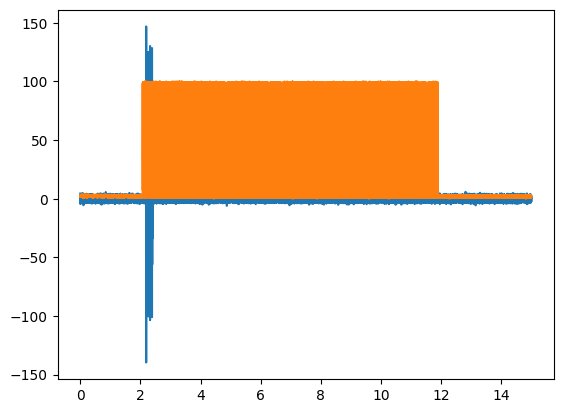

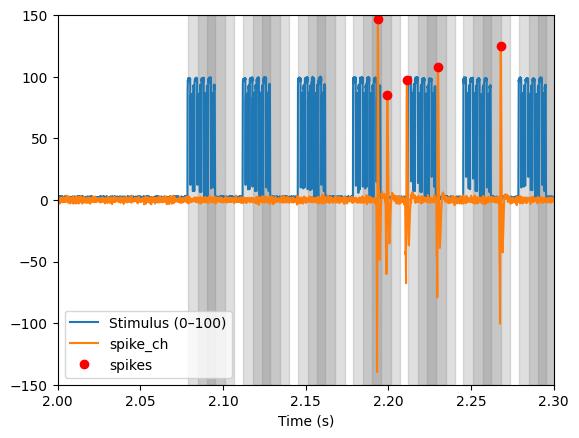

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from Neitz import Neitz
from pathlib import Path
from scipy.signal import find_peaks

PULSES_PER_BURST = 4
FRAME_S = 1/60  # one frame wide grey box

laser = Neitz(filepath=Path.cwd())
laser.abfread("2026_01_14_0007.abf")

# flip + normalize stim to 0..100
laser.stim_ch = -laser.stim_ch
laser.stim_ch = laser.stim_ch - laser.stim_ch.min()
laser.stim_ch = laser.stim_ch / laser.stim_ch.max() * 100
peaks, _ = find_peaks(laser.spike_ch, height=20)
# ---------- GREY BOX LOGIC (uniform, anchored to first pulse only) ----------
# laser.stim_ch is already flipped + normalized (0..100)
stim = laser.stim_ch
t = laser.time_vec

# detect rising edges of each pulse, then keep the first of each burst-of-4
thr = 50  # halfway on 0..100 scale
rise = np.where(np.diff((stim > thr).astype(int)) == 1)[0] + 1
rise_first = rise[::4]  # first pulse of each 4-pulse burst

plt.plot(t, laser.spike_ch, label="spike_ch")
plt.plot(t, stim, label="stim (0-100)")



# ---------- PLOT ----------
plt.figure()
plt.plot(laser.time_vec, laser.stim_ch, label="Stimulus (0–100)")
plt.plot(laser.time_vec, laser.spike_ch, label="spike_ch")

# if you already have peaks from find_peaks on spike_ch:
plt.plot(laser.time_vec[peaks], laser.spike_ch[peaks], "o", c="red", label="spikes")

# draw UNIFORM grey boxes (same width every time)
for i in rise_first:
    plt.axvspan(t[i], t[i] + 1/60, color="grey", alpha=0.25)  # 1 frame wide
    
plt.axis([2, 2.3, -150, 150])
plt.xlabel("Time (s)")
plt.legend()
plt.show()


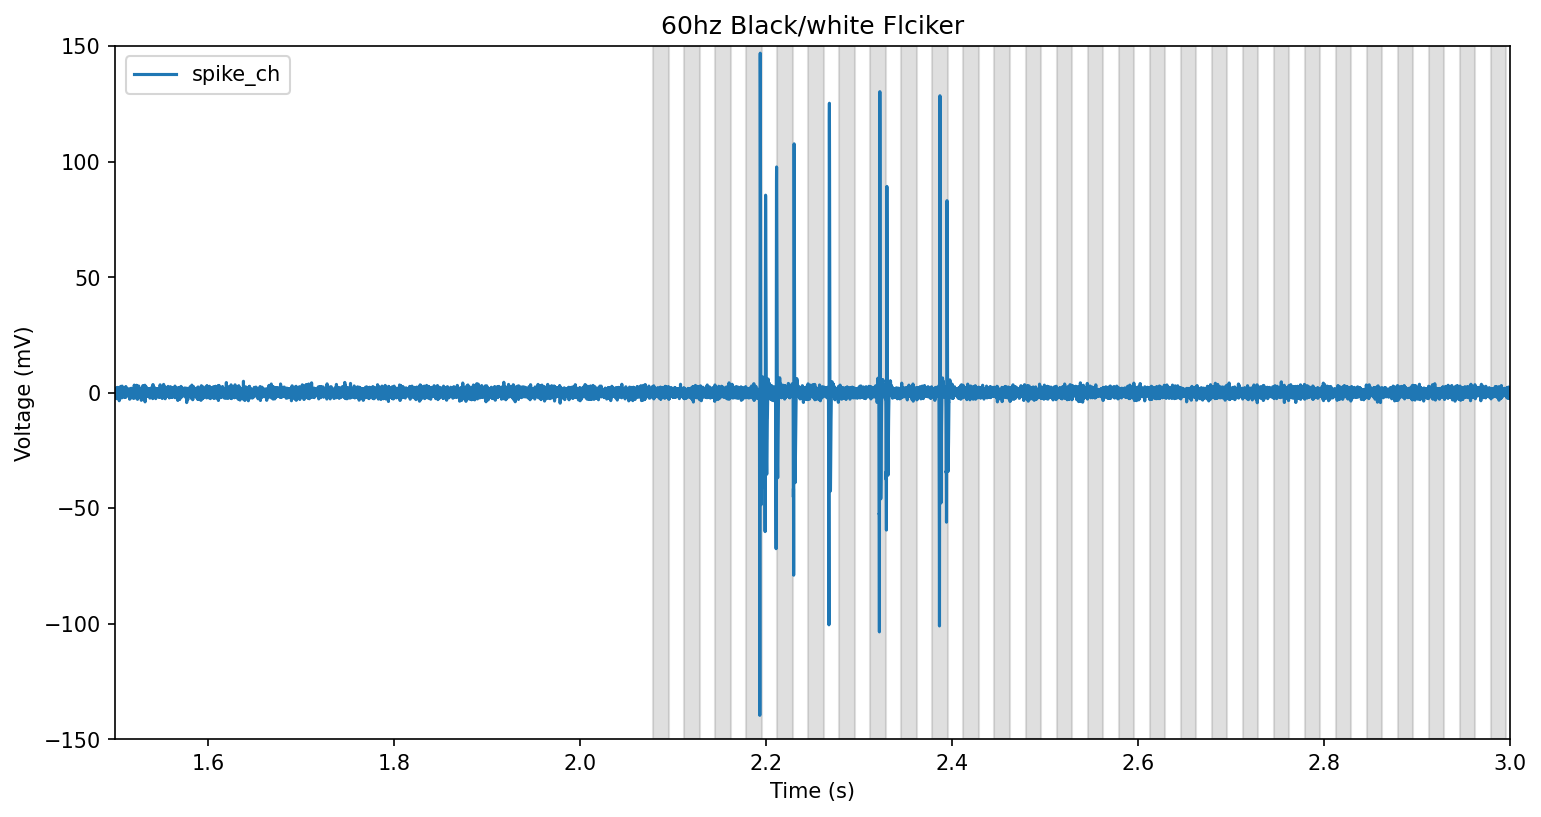

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Neitz import Neitz
from pathlib import Path

FRAME_S = 1/60                 # grey box width
ANCHOR_MIN_GAP_S = 0.03        # require >= 4 frames (~66.7 ms) between anchors (skips the 4-pulse burst)
CAL_DELAY_S = -0.00295
laser = Neitz(filepath=Path.cwd())
laser.abfread("2026_01_14_0007.abf")

# spikes
peaks, _ = find_peaks(laser.spike_ch, height=20)

# flip + normalize stim to 0..100
stim = -laser.stim_ch
stim = stim - stim.min()
stim = stim / stim.max() * 100
laser.stim_ch = stim

# rising edges of stim
thr = 50
rise = np.where(np.diff((laser.stim_ch > thr).astype(int)) == 1)[0] + 1
rise_t = laser.time_vec[rise]

# time-gated anchors: keep a rise only if it's >= ANCHOR_MIN_GAP_S after the last kept rise
anchor_t = []
last_t = -1e9
for t0 in rise_t:
    if (t0 - last_t) >= ANCHOR_MIN_GAP_S:
        anchor_t.append(t0)
        last_t = t0
anchor_t = np.asarray(anchor_t)
anchor_t_delayed = anchor_t + CAL_DELAY_S
# plot
plt.figure(figsize=(12, 6), dpi=150)
plt.plot(laser.time_vec, laser.spike_ch, label="spike_ch")
# plt.plot(laser.time_vec, laser.stim_ch, label="stim (0-100)")

for t0 in anchor_t:
    plt.axvspan(t0, t0 + FRAME_S, color="grey", alpha=0.25)

plt.axis([1.5, 3, -150, 150])
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("60hz Black/white Flciker")
plt.legend()
plt.show()



C:\Users\Brian\AppData\Local\Temp\ipykernel_7956\1868043329.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0,1,2,3,4,5])


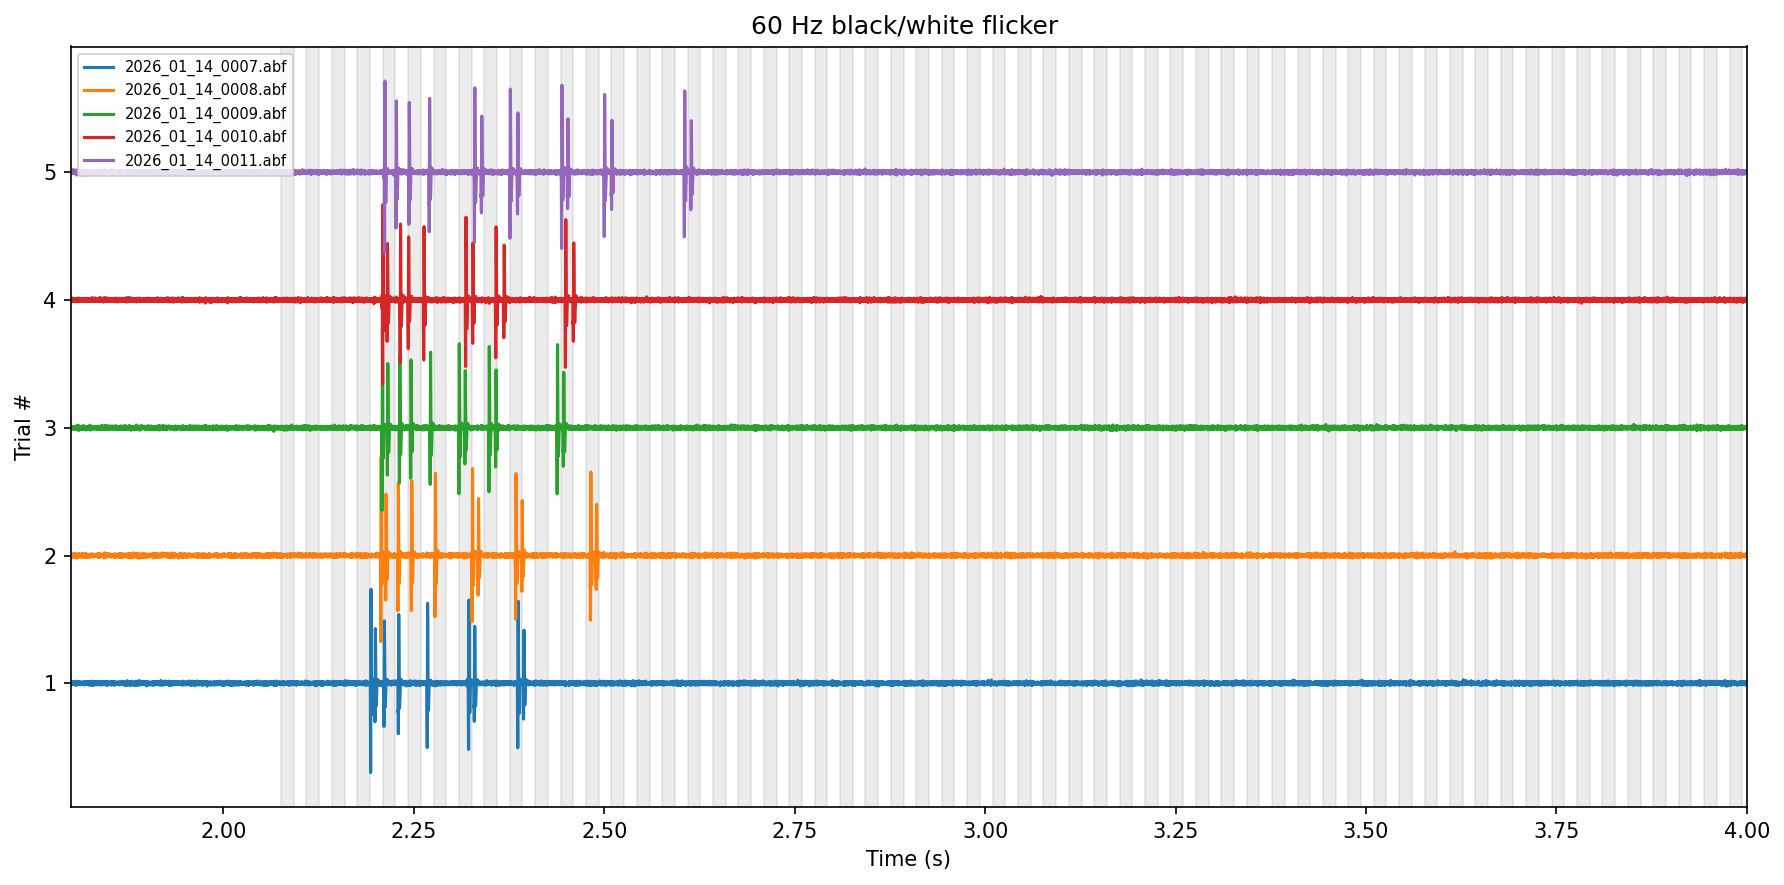

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Neitz import Neitz
from pathlib import Path

FRAME_S = 1/60
ANCHOR_MIN_GAP_S = 0.03
CAL_DELAY_S = -0.00295

START_NUM, END_NUM = 7, 11
DATE_STR = "2026_01_14"
Y_OFFSET_MV = 200
thr = 50

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

anchor_t_firstfile = None
for k, n in enumerate(range(START_NUM, END_NUM + 1)):
    fname = f"{DATE_STR}_{n:04d}.abf"

    laser = Neitz(filepath=Path.cwd())
    laser.abfread(fname)


    y = laser.spike_ch + k * Y_OFFSET_MV
    ax.plot(laser.time_vec, y, label=f"{fname}")


    if anchor_t_firstfile is None:
        stim = -laser.stim_ch
        stim = stim - stim.min()
        stim = stim / stim.max() * 100

        rise = np.where(np.diff((stim > thr).astype(int)) == 1)[0] + 1
        rise_t = laser.time_vec[rise]

        anchor_t = []
        last_t = -1e9
        for t0 in rise_t:
            if (t0 - last_t) >= ANCHOR_MIN_GAP_S:
                anchor_t.append(t0)
                last_t = t0
        anchor_t_firstfile = np.asarray(anchor_t) + CAL_DELAY_S


for t0 in anchor_t_firstfile:
    ax.axvspan(t0, t0 + FRAME_S, color="grey", alpha=0.15)

ax.set_xlim(1.8, 4)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Trial #")
ax.set_yticklabels([0,1,2,3,4,5])
ax.set_title("60 Hz black/white flicker ")
ax.legend(fontsize=7, loc="upper left")
plt.tight_layout()
plt.show()


C:\Users\Brian\AppData\Local\Temp\ipykernel_7956\3234884015.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0,0,1,2,3,4,5])


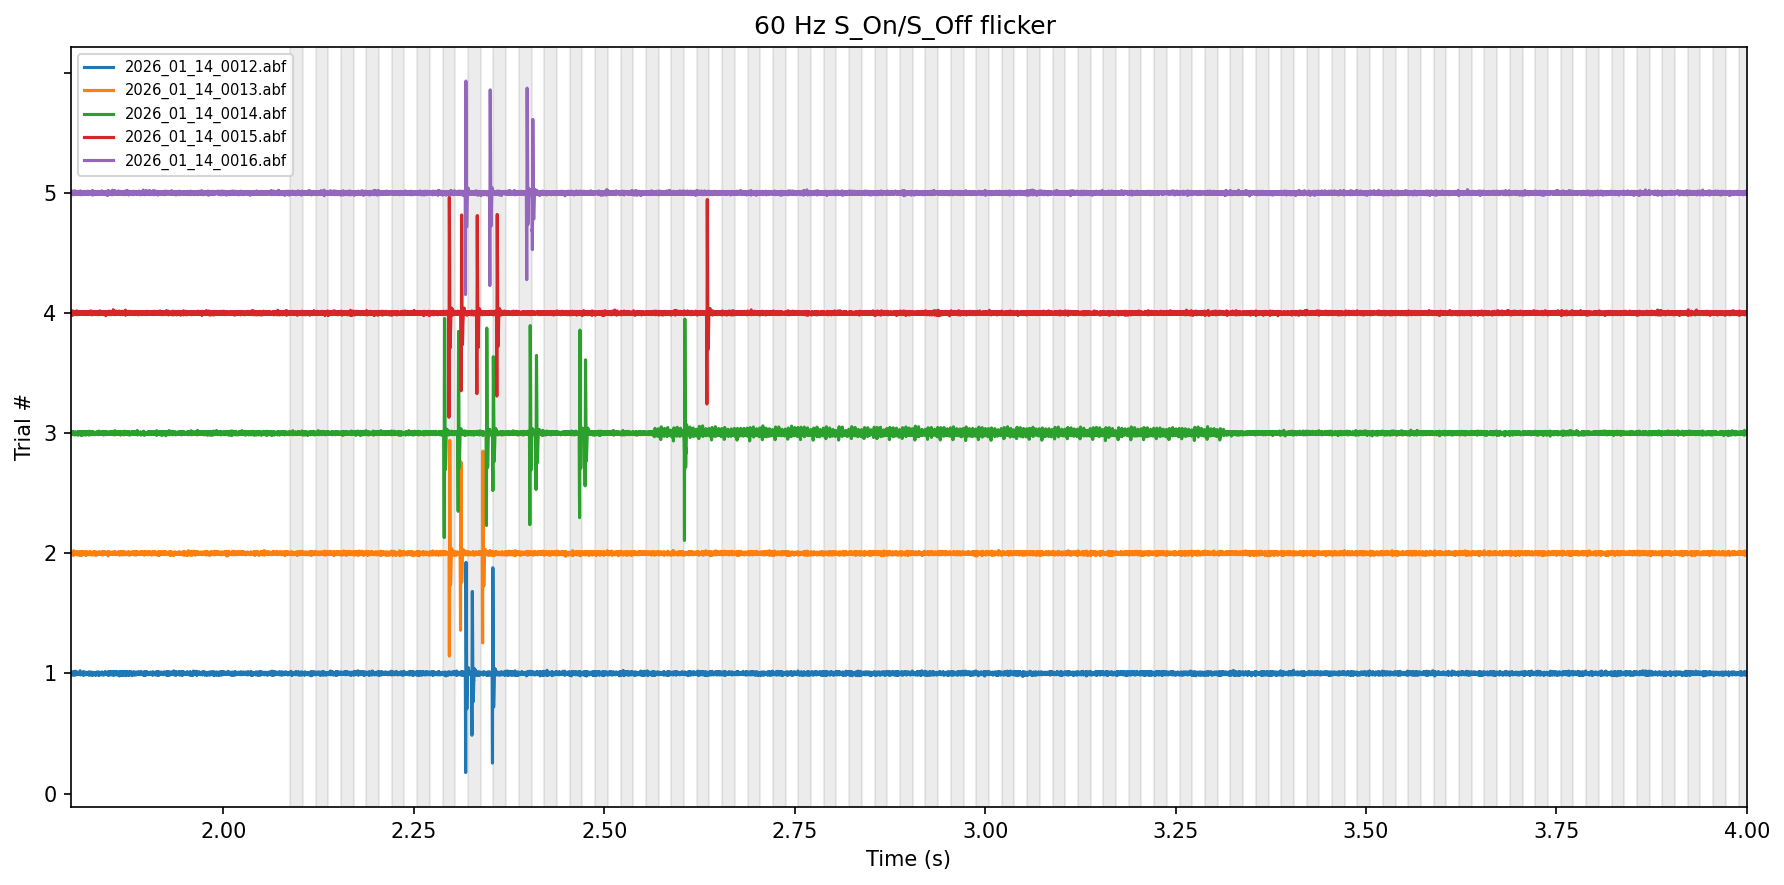

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Neitz import Neitz
from pathlib import Path

FRAME_S = 1/60
ANCHOR_MIN_GAP_S = 0.03
CAL_DELAY_S = -0.00295

START_NUM, END_NUM = 12, 16
DATE_STR = "2026_01_14"
Y_OFFSET_MV = 200
thr = 50

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

anchor_t_firstfile = None 

for k, n in enumerate(range(START_NUM, END_NUM + 1)):
    fname = f"{DATE_STR}_{n:04d}.abf"

    laser = Neitz(filepath=Path.cwd())
    laser.abfread(fname)


    y = laser.spike_ch + k * Y_OFFSET_MV
    ax.plot(laser.time_vec, y, label=f"{fname}")


    if anchor_t_firstfile is None:
        stim = -laser.stim_ch
        stim = stim - stim.min()
        stim = stim / stim.max() * 100

        rise = np.where(np.diff((stim > thr).astype(int)) == 1)[0] + 1
        rise_t = laser.time_vec[rise]

        anchor_t = []
        last_t = -1e9
        for t0 in rise_t:
            if (t0 - last_t) >= ANCHOR_MIN_GAP_S:
                anchor_t.append(t0)
                last_t = t0
        anchor_t_firstfile = np.asarray(anchor_t) + CAL_DELAY_S


for t0 in anchor_t_firstfile:
    ax.axvspan(t0, t0 + FRAME_S, color="grey", alpha=0.15)

ax.set_xlim(1.8, 4)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Trial #")
ax.set_yticklabels([0,0,1,2,3,4,5])
ax.set_title("60 Hz S_On/S_Off flicker ")
ax.legend(fontsize=7, loc="upper left")
plt.tight_layout()
plt.show()


C:\Users\Brian\AppData\Local\Temp\ipykernel_7956\1108258874.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0,1,2,3,4,5])


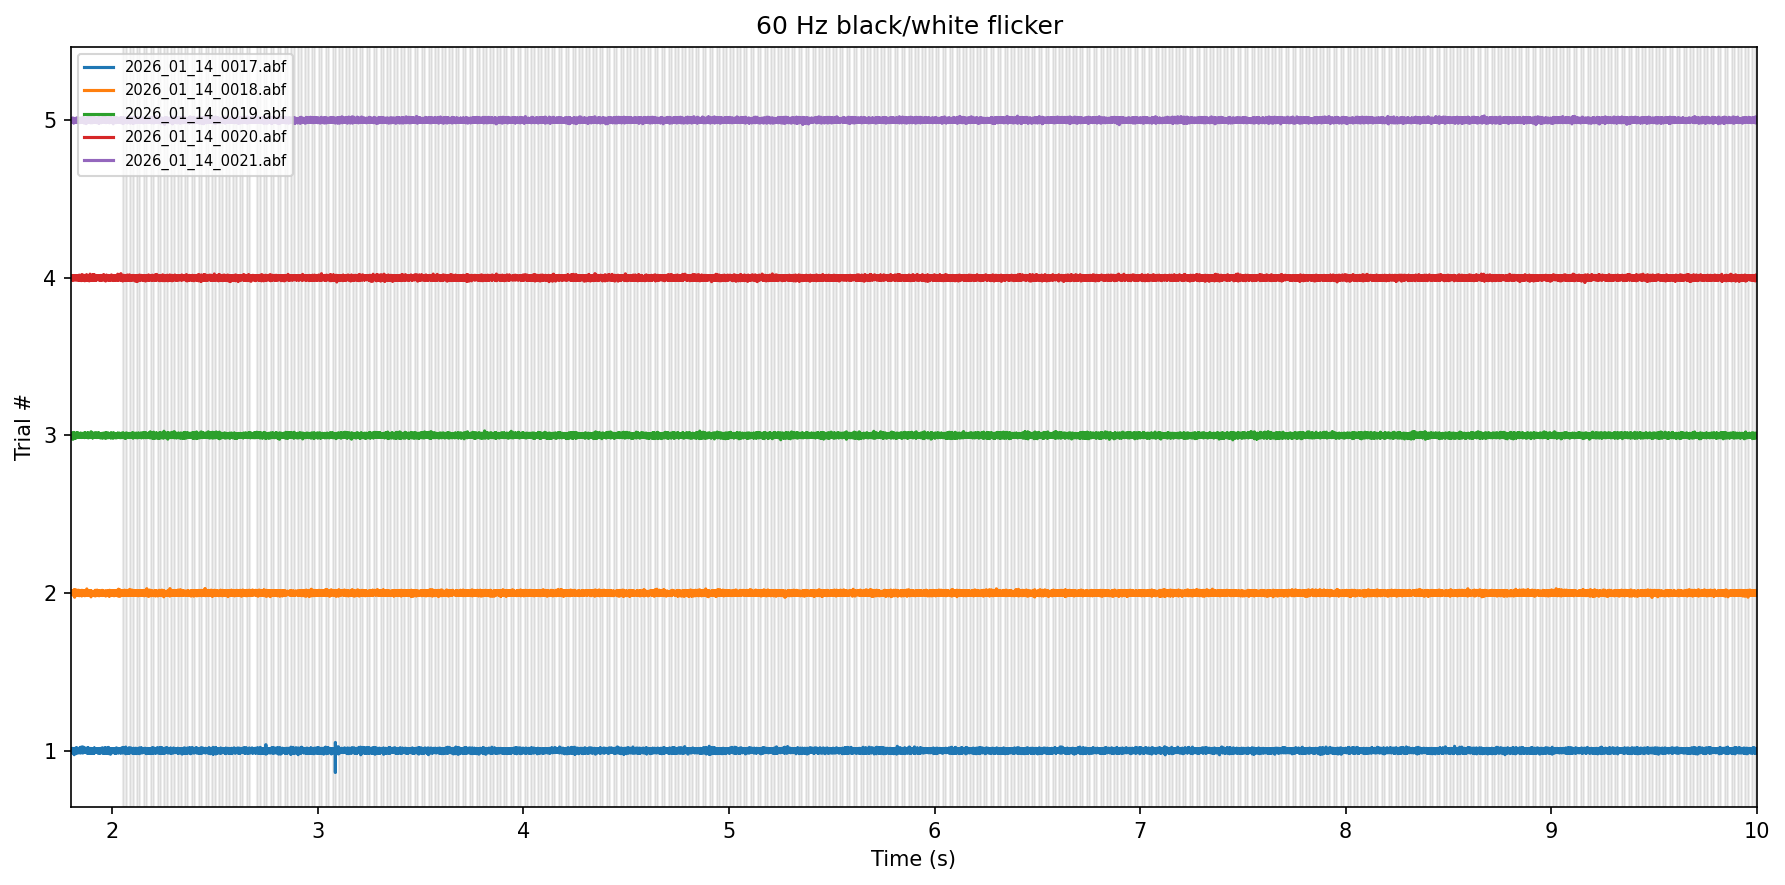

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Neitz import Neitz
from pathlib import Path

FRAME_S = 1/60
ANCHOR_MIN_GAP_S = 0.03
CAL_DELAY_S = -0.00295

START_NUM, END_NUM = 17, 21
DATE_STR = "2026_01_14"
Y_OFFSET_MV = 200
thr = 50

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

anchor_t_firstfile = None 

for k, n in enumerate(range(START_NUM, END_NUM + 1)):
    fname = f"{DATE_STR}_{n:04d}.abf"

    laser = Neitz(filepath=Path.cwd())
    laser.abfread(fname)


    y = laser.spike_ch + k * Y_OFFSET_MV
    ax.plot(laser.time_vec, y, label=f"{fname}")


    if anchor_t_firstfile is None:
        stim = -laser.stim_ch
        stim = stim - stim.min()
        stim = stim / stim.max() * 100

        rise = np.where(np.diff((stim > thr).astype(int)) == 1)[0] + 1
        rise_t = laser.time_vec[rise]

        anchor_t = []
        last_t = -1e9
        for t0 in rise_t:
            if (t0 - last_t) >= ANCHOR_MIN_GAP_S:
                anchor_t.append(t0)
                last_t = t0
        anchor_t_firstfile = np.asarray(anchor_t) + CAL_DELAY_S


for t0 in anchor_t_firstfile:
    ax.axvspan(t0, t0 + FRAME_S, color="grey", alpha=0.15)

ax.set_xlim(1.8, 10)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Trial #")
ax.set_yticklabels([0,1,2,3,4,5])
ax.set_title("60 Hz black/white flicker ")
ax.legend(fontsize=7, loc="upper left")
plt.tight_layout()
plt.show()

C:\Users\Brian\AppData\Local\Temp\ipykernel_7956\2470036079.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0,1,2,3,4,5])


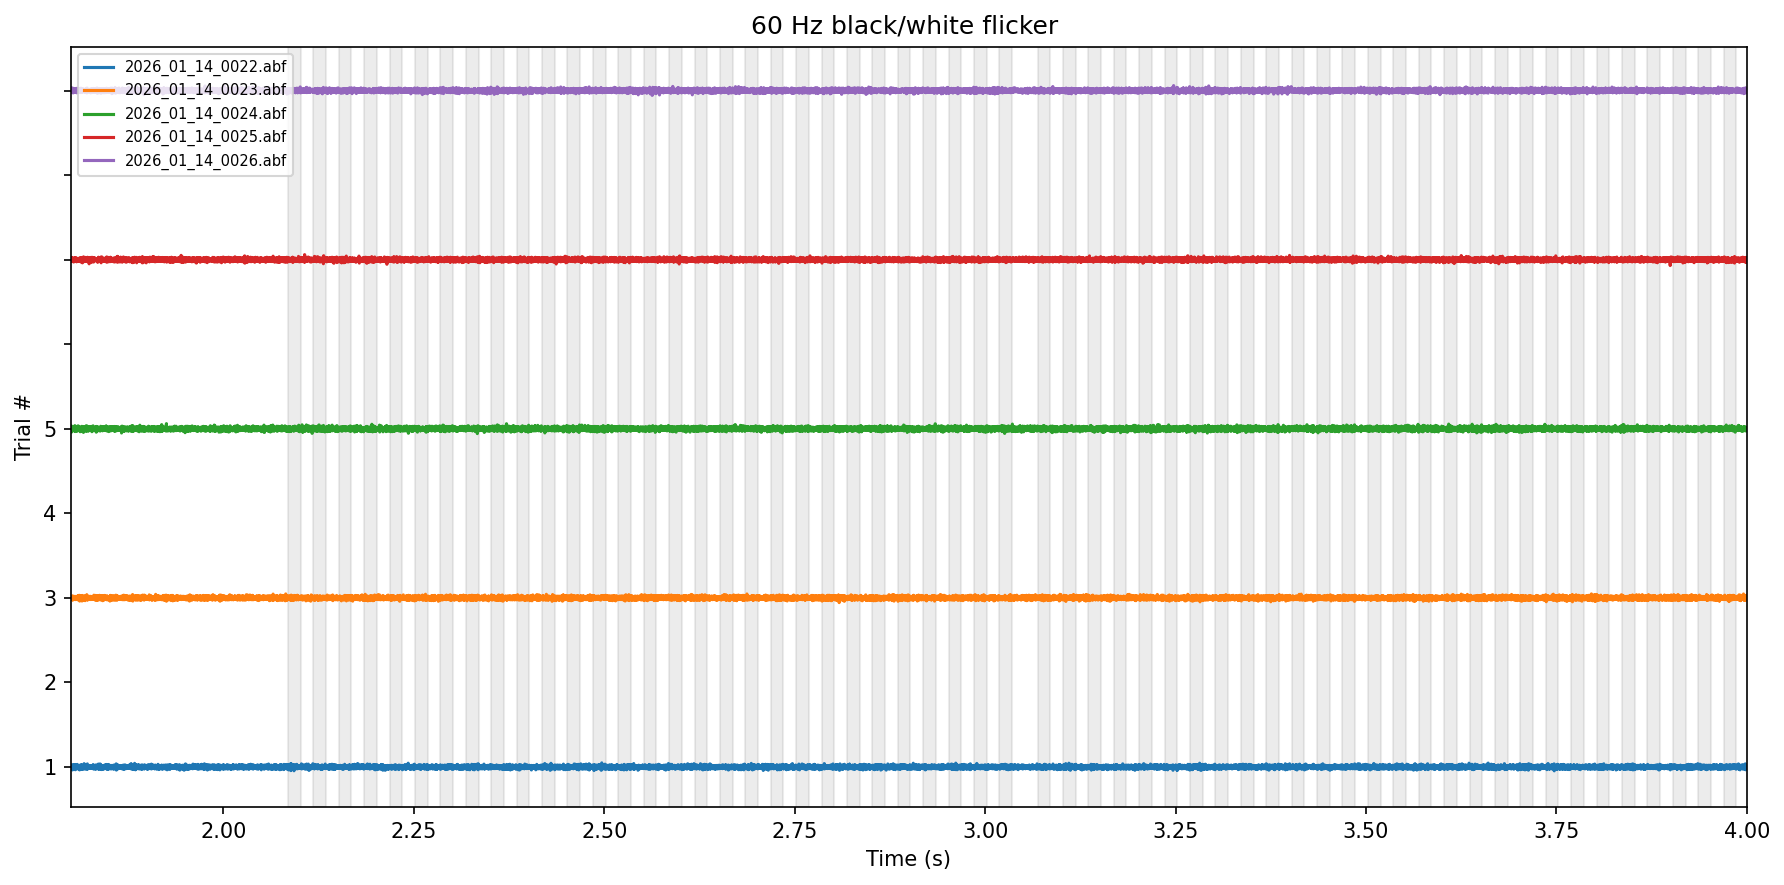

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Neitz import Neitz
from pathlib import Path

FRAME_S = 1/60
ANCHOR_MIN_GAP_S = 0.03
CAL_DELAY_S = -0.00295

START_NUM, END_NUM = 22, 26
DATE_STR = "2026_01_14"
Y_OFFSET_MV = 200
thr = 50

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

anchor_t_firstfile = None 

for k, n in enumerate(range(START_NUM, END_NUM + 1)):
    fname = f"{DATE_STR}_{n:04d}.abf"

    laser = Neitz(filepath=Path.cwd())
    laser.abfread(fname)


    y = laser.spike_ch + k * Y_OFFSET_MV
    ax.plot(laser.time_vec, y, label=f"{fname}")


    if anchor_t_firstfile is None:
        stim = -laser.stim_ch
        stim = stim - stim.min()
        stim = stim / stim.max() * 100

        rise = np.where(np.diff((stim > thr).astype(int)) == 1)[0] + 1
        rise_t = laser.time_vec[rise]

        anchor_t = []
        last_t = -1e9
        for t0 in rise_t:
            if (t0 - last_t) >= ANCHOR_MIN_GAP_S:
                anchor_t.append(t0)
                last_t = t0
        anchor_t_firstfile = np.asarray(anchor_t) + CAL_DELAY_S


for t0 in anchor_t_firstfile:
    ax.axvspan(t0, t0 + FRAME_S, color="grey", alpha=0.15)

ax.set_xlim(1.8, 4)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Trial #")
ax.set_yticklabels([0,1,2,3,4,5])
ax.set_title("60 Hz black/white flicker ")
ax.legend(fontsize=7, loc="upper left")
plt.tight_layout()
plt.show()

C:\Users\Brian\AppData\Local\Temp\ipykernel_7956\1074529156.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0,1,2,3,4,5])


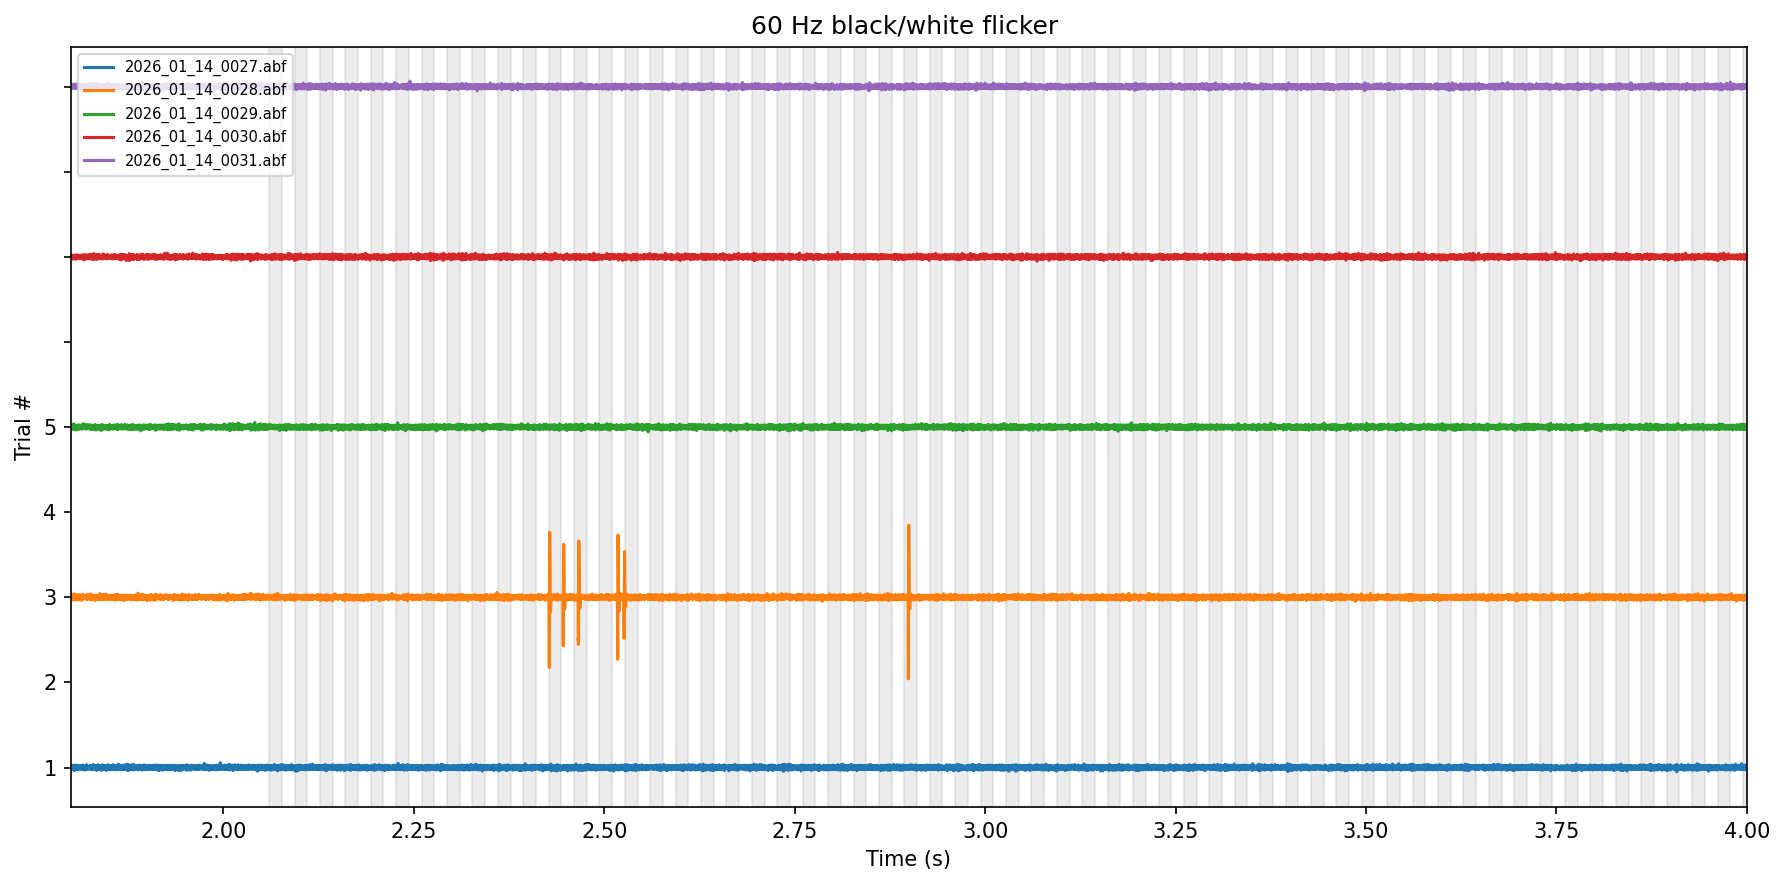

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Neitz import Neitz
from pathlib import Path

FRAME_S = 1/60
ANCHOR_MIN_GAP_S = 0.03
CAL_DELAY_S = -0.00295

START_NUM, END_NUM = 27, 31
DATE_STR = "2026_01_14"
Y_OFFSET_MV = 200
thr = 50

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

anchor_t_firstfile = None 

for k, n in enumerate(range(START_NUM, END_NUM + 1)):
    fname = f"{DATE_STR}_{n:04d}.abf"

    laser = Neitz(filepath=Path.cwd())
    laser.abfread(fname)


    y = laser.spike_ch + k * Y_OFFSET_MV
    ax.plot(laser.time_vec, y, label=f"{fname}")


    if anchor_t_firstfile is None:
        stim = -laser.stim_ch
        stim = stim - stim.min()
        stim = stim / stim.max() * 100

        rise = np.where(np.diff((stim > thr).astype(int)) == 1)[0] + 1
        rise_t = laser.time_vec[rise]

        anchor_t = []
        last_t = -1e9
        for t0 in rise_t:
            if (t0 - last_t) >= ANCHOR_MIN_GAP_S:
                anchor_t.append(t0)
                last_t = t0
        anchor_t_firstfile = np.asarray(anchor_t) + CAL_DELAY_S


for t0 in anchor_t_firstfile:
    ax.axvspan(t0, t0 + FRAME_S, color="grey", alpha=0.15)

ax.set_xlim(1.8, 4)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Trial #")
ax.set_yticklabels([0,1,2,3,4,5])
ax.set_title("60 Hz black/white flicker ")
ax.legend(fontsize=7, loc="upper left")
plt.tight_layout()
plt.show()

Using anchors as ON transitions: n=295


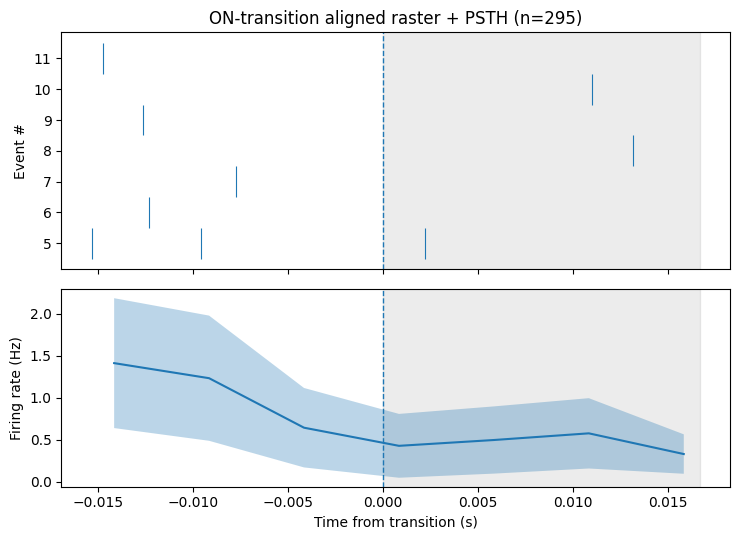

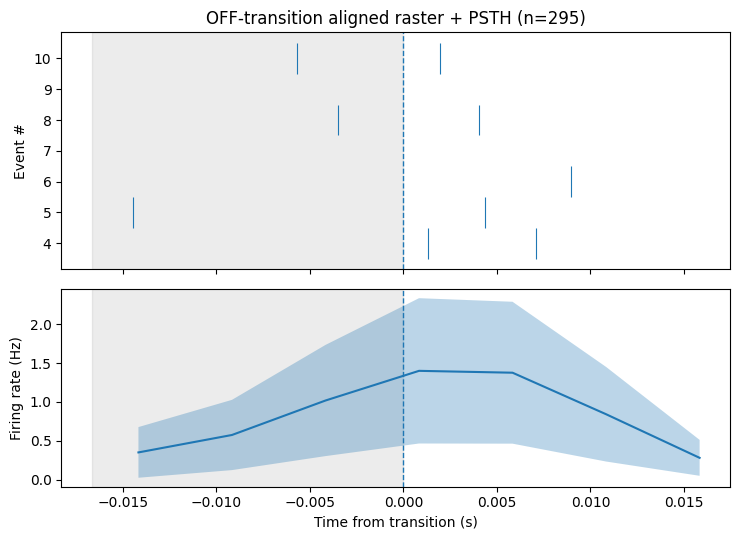

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Neitz import Neitz
from pathlib import Path

# ----------------------------
# Settings (match your existing logic)
# ----------------------------
ABF_NAME = "2026_01_14_0007.abf"

CAL_DELAY_S = -0.00295     # seconds
THR_NORM = 50              # stim threshold after 0..100 normalization
ANCHOR_MIN_GAP_S = 0.03    # your time-gating that worked
ON_DUR_S = 1/60            # this is what your grey box represents (one "ON" frame)

# Raster/PSTH window
WIN_PRE_S  = 1/60
WIN_POST_S = 1/60
BIN_S      = 0.005

SPIKE_HEIGHT = 20
SMOOTH_SIGMA_S = 0.003  # 3 ms; tune (e.g., 0.002–0.005)
# ----------------------------
# Helpers
# ----------------------------
def raster_psth(spike_t, event_t, pre_s, post_s, bin_s):
    edges = np.arange(-pre_s, post_s + bin_s, bin_s)
    centers = (edges[:-1] + edges[1:]) / 2

    rel_spikes_per_event = []
    per_event_rates = []

    for t0 in event_t:
        rel = spike_t - t0
        rel = rel[(rel >= -pre_s) & (rel <= post_s)]
        rel_spikes_per_event.append(rel)

        counts, _ = np.histogram(rel, bins=edges)
        per_event_rates.append(counts / bin_s)  # Hz

    per_event_rates = np.asarray(per_event_rates)
    mean_rate = per_event_rates.mean(axis=0) if len(per_event_rates) else np.zeros_like(centers)

    if per_event_rates.shape[0] > 1:
        sem_rate = per_event_rates.std(axis=0, ddof=1) / np.sqrt(per_event_rates.shape[0])
    else:
        sem_rate = np.zeros_like(mean_rate)

    return rel_spikes_per_event, centers, mean_rate, sem_rate

def plot_raster_psth(rel_spikes_per_event, centers, mean_rate, sem_rate, title, shade_window=None):
    fig, (ax_r, ax_p) = plt.subplots(
        2, 1, figsize=(7.5, 5.5),
        gridspec_kw={"height_ratios": [1.2, 1.0]},
        sharex=True
    )

    # Raster
    for i, rel in enumerate(rel_spikes_per_event):
        if len(rel):
            ax_r.vlines(rel, i + 0.5, i + 1.5, linewidth=0.8)

    ax_r.axvline(0, linestyle="--", linewidth=1)
    ax_r.set_ylabel("Event #")
    ax_r.set_title(title)

    # Shade a fixed stimulus window relative to transition (optional)
    if shade_window is not None:
        a, b = shade_window
        ax_r.axvspan(a, b, color="grey", alpha=0.15)
        ax_p.axvspan(a, b, color="grey", alpha=0.15)

    # PSTH
    ax_p.plot(centers, mean_rate)
    ax_p.fill_between(centers, mean_rate - sem_rate, mean_rate + sem_rate, alpha=0.3)
    ax_p.axvline(0, linestyle="--", linewidth=1)
    ax_p.set_xlabel("Time from transition (s)")
    ax_p.set_ylabel("Firing rate (Hz)")

    plt.tight_layout()
    plt.show()
    
def gaussian_smooth(y, sigma_bins):
    """Length-preserving Gaussian smoothing on 1D array y."""
    y = np.asarray(y, dtype=float)
    sigma_bins = int(max(1, sigma_bins))
    half = int(3 * sigma_bins)          # keep kernel compact
    x = np.arange(-half, half + 1)      # odd length
    k = np.exp(-(x**2) / (2 * sigma_bins**2))
    k /= k.sum()
    return np.convolve(y, k, mode="same")

# ----------------------------
# Load data
# ----------------------------
laser = Neitz(filepath=Path.cwd())
laser.abfread(ABF_NAME)

t = laser.time_vec
spk = laser.spike_ch

# spikes
spike_idx, _ = find_peaks(spk, height=SPIKE_HEIGHT)
spike_t = t[spike_idx]

# stim: flip + normalize 0..100 (as you do)
stim = -laser.stim_ch
stim = stim - stim.min()
stim = stim / stim.max() * 100

sigma_bins = int(round(SMOOTH_SIGMA_S / BIN_S))
# ----------------------------
# ON transitions = your proven anchors (time-gated rising edges)
# ----------------------------
rise_idx = np.where(np.diff((stim > THR_NORM).astype(int)) == 1)[0] + 1
rise_t = t[rise_idx]

anchor_t = []
last_t = -1e9
for tt in rise_t:
    if (tt - last_t) >= ANCHOR_MIN_GAP_S:
        anchor_t.append(tt)
        last_t = tt
anchor_t = np.asarray(anchor_t)

on_times = anchor_t + CAL_DELAY_S
off_times = on_times + ON_DUR_S  # define "OFF transition" as end of that ON window

print(f"Using anchors as ON transitions: n={len(on_times)}")

# ----------------------------
# ON-aligned raster + PSTH (shade the ON window [0, ON_DUR_S])
# ----------------------------
on_rel, centers, on_mean, on_sem = raster_psth(spike_t, on_times, WIN_PRE_S, WIN_POST_S, BIN_S)
on_mean = gaussian_smooth(on_mean, sigma_bins)
on_sem  = gaussian_smooth(on_sem,  sigma_bins)

plot_raster_psth(
    on_rel, centers, on_mean, on_sem,
    title=f"ON-transition aligned raster + PSTH (n={len(on_times)})",
    shade_window=(0, ON_DUR_S)
)

# ----------------------------
# OFF-aligned raster + PSTH (shade the preceding ON window [-ON_DUR_S, 0])
# ----------------------------
off_rel, centers, off_mean, off_sem = raster_psth(spike_t, off_times, WIN_PRE_S, WIN_POST_S, BIN_S)
off_mean = gaussian_smooth(off_mean, sigma_bins)
off_sem  = gaussian_smooth(off_sem,  sigma_bins)

plot_raster_psth(
    off_rel, centers, off_mean, off_sem,
    title=f"OFF-transition aligned raster + PSTH (n={len(off_times)})",
    shade_window=(-ON_DUR_S, 0)
)

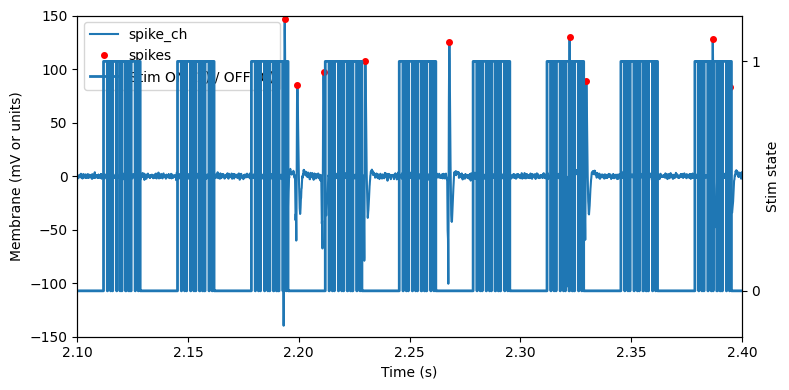

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

t = laser.time_vec
spk = laser.spike_ch

# spikes (optional markers)
peaks, _ = find_peaks(spk, height=20)

# make a clean ON/OFF vector from stim (works whether it's 0/5V or your 0–100 normalized)
stim = laser.stim_ch
thr = (np.nanmin(stim) + np.nanmax(stim)) / 2
on = (stim > thr).astype(int)  # 0 = OFF, 1 = ON

fig, ax1 = plt.subplots(figsize=(8,4))

# spike trace
ax1.plot(t, spk, label="spike_ch")
ax1.plot(t[peaks], spk[peaks], "o", c="red", ms=4, label="spikes")
ax1.set_ylabel("Membrane (mV or units)")
ax1.set_xlabel("Time (s)")
ax1.set_xlim(2.10, 2.40)
ax1.set_ylim(-150, 150)

# ON/OFF bar (binary), drawn as a step on a second axis
ax2 = ax1.twinx()
ax2.step(t, on, where="post", linewidth=2, label="Stim ON (1) / OFF (0)")
ax2.set_ylim(-0.2, 1.2)
ax2.set_yticks([0, 1])
ax2.set_ylabel("Stim state")

# combined legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper left")

plt.tight_layout()
plt.show()


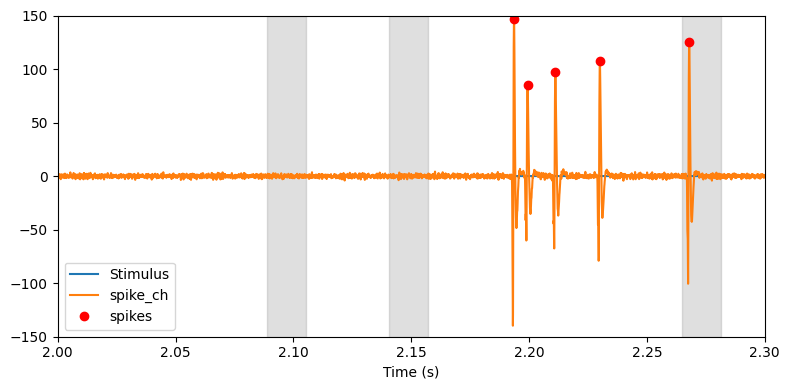

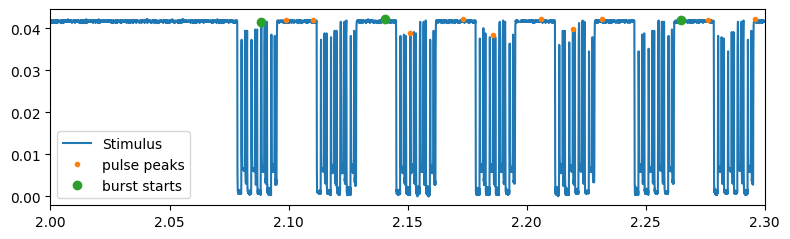

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ---------- tune these ----------
PROM = 0.02          # peak prominence in stim_ch units (tune)
HEIGHT = None        # or set a minimum height
MIN_PEAK_DIST_S = 0.010   # minimum distance between pulse peaks (seconds)
GAP_S = 0.030        # gap that indicates "new burst" (seconds). > intra-pulse spacing
BOX_S = 1/60         # width of the grey box (one frame). use 1/30 if you prefer

# ---------- detect pulse peaks in stim channel ----------
dt = float(np.median(np.diff(time_vec)))
min_dist = int(round(MIN_PEAK_DIST_S / dt))

stim = stim_ch.copy()

pulse_peaks, props = find_peaks(stim, prominence=PROM, height=HEIGHT, distance=min_dist)
if len(pulse_peaks) == 0:
    raise RuntimeError("No stim peaks found. Lower PROM/HEIGHT or check stim_ch polarity.")

peak_t = time_vec[pulse_peaks]

# ---------- burst starts = first peak after a large gap ----------
gap_mask = np.diff(peak_t) > GAP_S
burst_start_peaks = np.r_[pulse_peaks[0], pulse_peaks[1:][gap_mask]]
burst_start_t = time_vec[burst_start_peaks]

# ---------- plot with stim overlay + burst-start boxes ----------
fig, ax = plt.subplots(figsize=(8,4))

# stim trace (blue) and spike trace (orange)
ax.plot(time_vec, stim_ch, label="Stimulus")
ax.plot(time_vec, spike_ch, label="spike_ch")
ax.plot(time_vec[peaks], spike_ch[peaks], "o", c="red", label="spikes")

# grey box at first pulse of each burst
for t0 in burst_start_t:
    ax.axvspan(t0, t0 + BOX_S, color="grey", alpha=0.25)

# optional zoom
ax.set_xlim(2.0, 2.3)
ax.set_ylim(-150, 150)
ax.set_xlabel("Time (s)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

# (optional) sanity check: show peak markers on stim
plt.figure(figsize=(8,2.5))
plt.plot(time_vec, stim_ch, label="Stimulus")
plt.plot(time_vec[pulse_peaks], stim_ch[pulse_peaks], "o", ms=3, label="pulse peaks")
plt.plot(time_vec[burst_start_peaks], stim_ch[burst_start_peaks], "o", ms=6, label="burst starts")
plt.xlim(2.0, 2.3)
plt.legend()
plt.tight_layout()
plt.show()


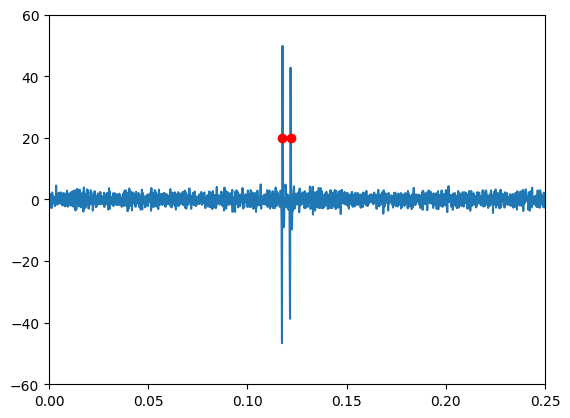

(np.float64(0.0), np.float64(5.0), np.float64(-60.0), np.float64(60.0))

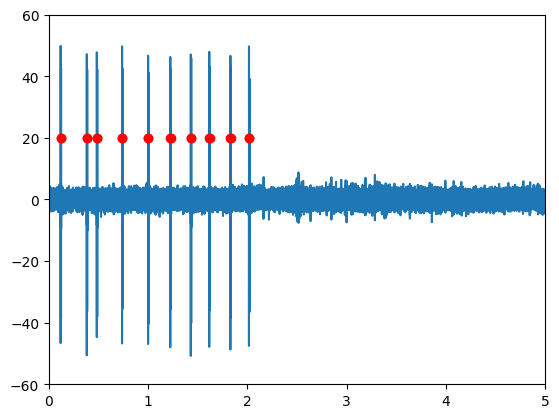

In [3]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
peaks, _ = find_peaks(spike_ch, height = 20)
plt.plot(time_vec,spike_ch)
plt.plot(peaks/2e4,[20]*len(peaks),'o',c = 'red')
plt.axis([0, 0.25, -60, 60])
plt.show()


plt.plot(time_vec,spike_ch)
plt.plot(peaks/2e4,[20]*len(peaks),'o',c = 'red')
plt.axis([0, 5, -60, 60])

In [4]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Change filename as needed
df = pd.read_csv("data/2025_12_04_0001.csv", header=None)


t_60 = df.iloc[:, 1].to_numpy()  
x_60 = df.iloc[:, 2].to_numpy()  


order = np.argsort(t_60)
t_60 = t_60[order]
x_60 = x_60[order]


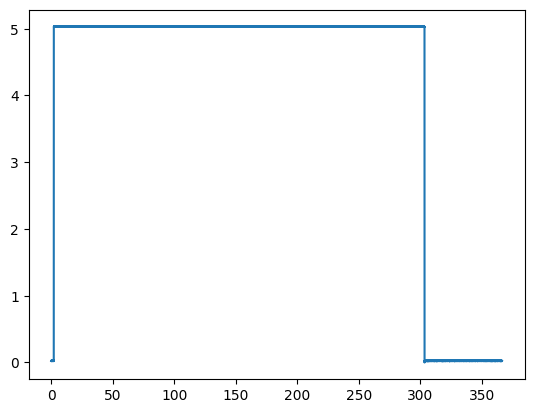

In [11]:
plt.plot(time_vec,stim_ch)

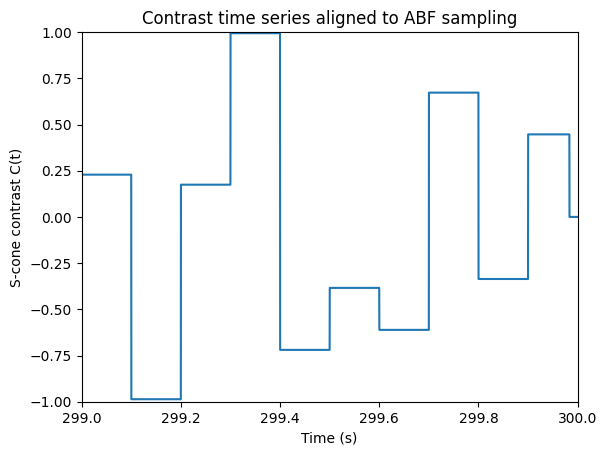

In [9]:
import matplotlib.pyplot as plt
import numpy as np

is_on = stim_ch > 1
edges = np.diff(is_on.astype(int))
fall_idxs = np.where(edges == -1)[0] + 1  
rise_idxs = np.where(edges ==  1)[0] + 1   

i_on = rise_idxs[0]
i_off  = fall_idxs[0]


t_on  = time_vec[i_on]
t_off = time_vec[i_off]


csv = pd.read_csv("data/2025_12_04_0001.csv")

t_60 = csv.iloc[:, 1].to_numpy()
y_60 = csv.iloc[:, 2].to_numpy()

y0 = y_60.mean()
C_60 = (y_60 - y0) / y0

contrast_interp = interp1d(
    t_60, C_60,
    kind='previous',     
    bounds_error=False,
    fill_value=(0.0, 0.0)
)
C_20k = contrast_interp(time_vec)   

plt.plot(time_vec, C_20k)
plt.xlabel("Time (s)")
plt.ylabel("S-cone contrast C(t)")
plt.title("Contrast time series aligned to ABF sampling")
plt.axis([299,300,-1,1])
plt.show()

segments.shape: (2698, 4000)


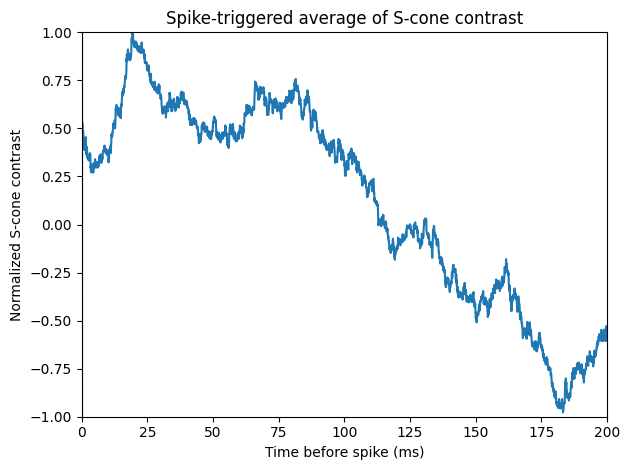

In [17]:
import numpy as np

dt = np.mean(np.diff(time_vec))
fs = 1.0 / dt

window_s = 0.2   # 200 ms
window_n = int(window_s * fs)


spike_times = time_vec[peaks]

mask_spikes = (spike_times >= t_on + 1.0) & (spike_times <= t_off)
peaks_used  = peaks[mask_spikes]

segments = []

for p in peaks_used:

    if p < window_n:
        continue
    if p > len(C_20k):
        continue

    seg = C_20k[p - window_n : p]

    if len(seg) == window_n:
        segments.append(seg)

segments = np.array(segments)  
print("segments.shape:", segments.shape)

sta = segments.mean(axis=0)


sta_rev = sta[::-1]
peak_sta = np.max(np.abs(sta_rev))
sta_norm = sta_rev / peak_sta

lags_ms = np.arange(window_n) * dt * 1000

plt.figure()
plt.plot(lags_ms, sta_norm)
plt.axvline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel("Time before spike (ms)")
plt.ylabel("Normalized S-cone contrast")
plt.title("Spike-triggered average of S-cone contrast")
plt.axis([0, 200,-1,1])
plt.tight_layout()
plt.show()


In [1]:
from Neitz import Neitz
from pathlib import Path

x = Neitz(filepath=Path.cwd())
x.abfread("2025_12_04_0001.abf")
x.find_spikes()
x.find_stim_on_off()
x.load_csv("2025_12_04_0001.csv")
x.align_contrast()
x.compute_sta()

time_vec = x.time_vec
spike_ch = x.spike_ch
stim_ch = x.stim_ch
peaks = x.peaks
sta_norm = x.sta_norm


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

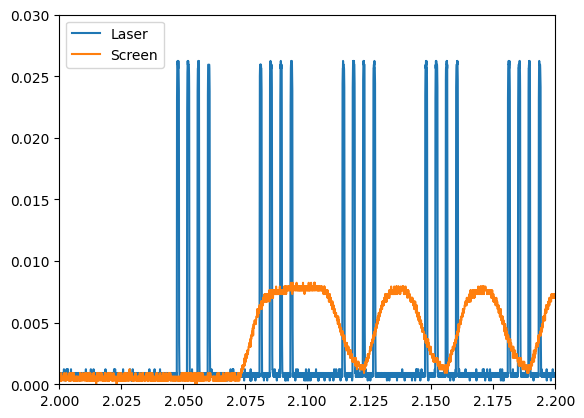

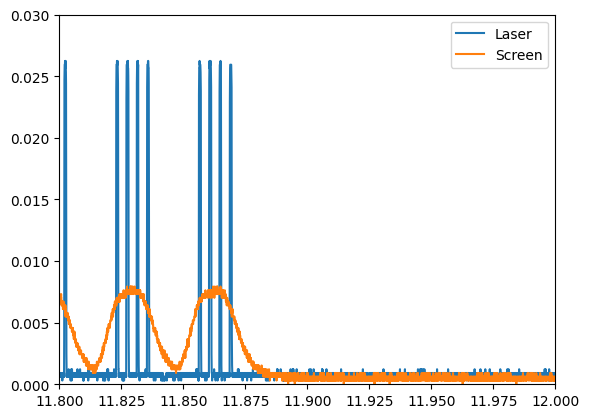

In [2]:
from Neitz import Neitz
from pathlib import Path
import matplotlib.pyplot as plt

laser = Neitz(filepath=Path.cwd())
laser.abfread("2025_12_18_0002_laser.abf")
laser.stim_ch = (laser.stim_ch)*-1
laser.stim_ch = laser.stim_ch - min(laser.stim_ch)

screen = Neitz(filepath=Path.cwd())
screen.abfread("2025_12_18_0001_screen.abf")
screen.stim_ch = (screen.stim_ch)*-1
screen.stim_ch = screen.stim_ch - min(screen.stim_ch)

plt.plot(laser.time_vec ,laser.stim_ch)
plt.plot(screen.time_vec ,screen.stim_ch)
plt.axis([2, 2.2, 0, 0.03])
plt.legend(["Laser", "Screen"])


plt.figure()
plt.plot(laser.time_vec ,laser.stim_ch)
plt.plot(screen.time_vec ,screen.stim_ch)
plt.axis([11.8, 12, 0, 0.03])
plt.legend(["Laser", "Screen"])

<function matplotlib.pyplot.show(close=None, block=None)>

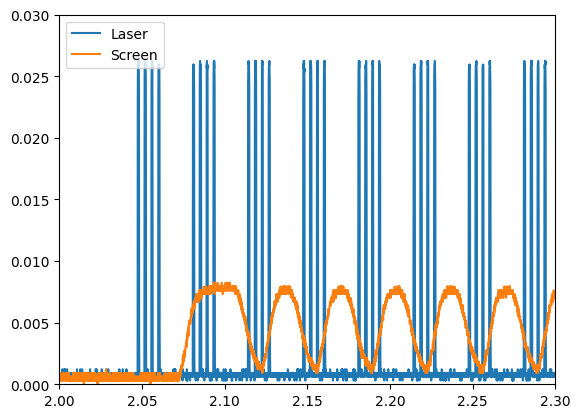

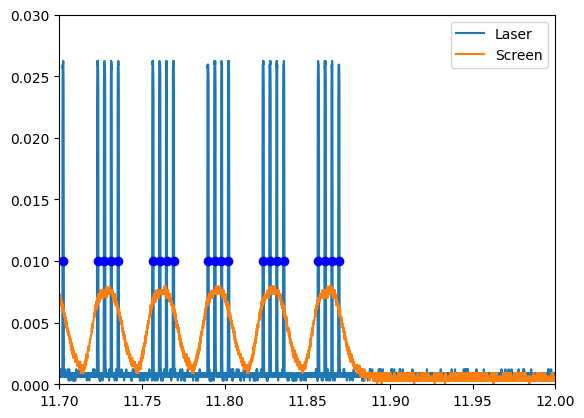

In [96]:
from scipy.signal import find_peaks
laser.peak_height = 0.01
laser.peaks, _ = find_peaks(laser.stim_ch, laser.peak_height,distance=int(1/1000*2e4))

fs = screen.fs 
screen.peak_height     = 0.004      
min_distance_s  = 1/60      # 10 ms between peaks (adjust as needed)
min_distance_n  = int(min_distance_s * fs)

screen.peaks, _ = find_peaks(
    screen.stim_ch,
    height=screen.peak_height,
    distance=min_distance_n
)
# screen.peaks, _ = find_peaks(screen.stim_ch, screen.peak_height)

plt.figure()
plt.plot(laser.time_vec ,laser.stim_ch)
plt.plot(screen.time_vec ,screen.stim_ch)
plt.axis([2, 2.3,0,0.03 ])
plt.legend(["Laser", "Screen"],loc= "upper left")


plt.figure()
plt.plot(laser.time_vec ,laser.stim_ch)
plt.plot(screen.time_vec ,screen.stim_ch)
plt.plot(laser.peaks/2e4,[laser.peak_height]*len(laser.peaks),'o',c = 'blue')
# plt.plot(screen.peaks/2e4,[screen.peak_height]*len(screen.peaks),'o',c = 'orange')
plt.legend(["Laser", "Screen"])
plt.axis([11.7, 12,0,0.03 ])
plt.show



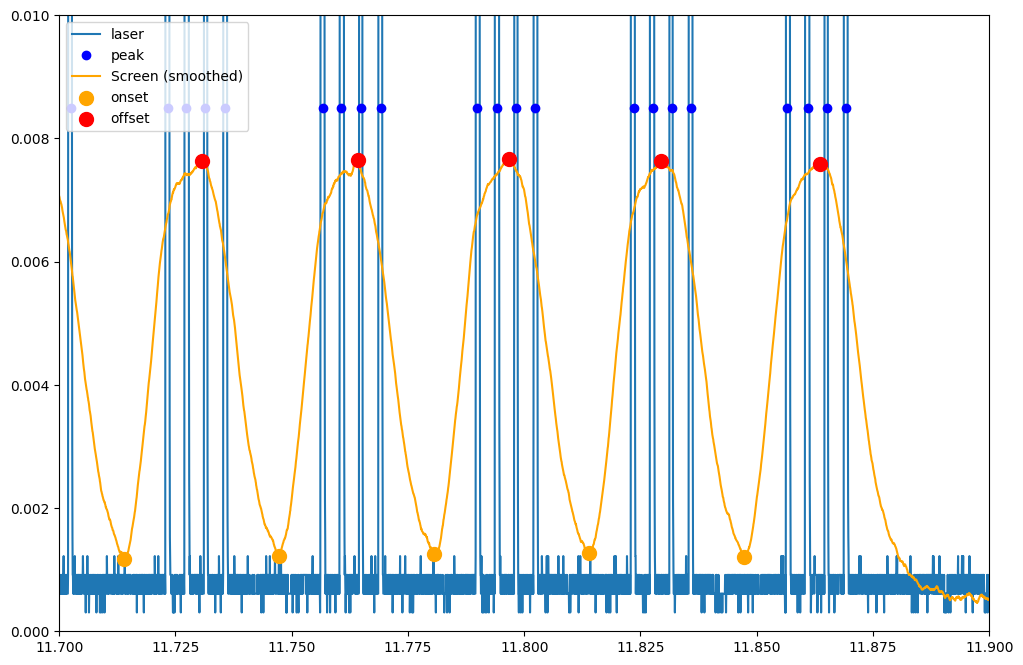

In [120]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt

sig_raw = screen.stim_ch
t       = screen.time_vec
fs      = screen.fs

# 1) Smooth
window_ms  = 2.5
window_len = int(window_ms * 1e-3 * fs)
if window_len % 2 == 0:
    window_len += 1
sig = savgol_filter(sig_raw, window_length=window_len, polyorder=3)

# 2) Maxima = offsets (tops)
max_idx, _ = find_peaks(
    sig,
    height=0.003,
    prominence=0.0005,
    distance=int(0.02 * fs)
)

# 3) Minima = candidates for onsets
min_idx, _ = find_peaks(
    -sig,
    prominence=0.0003,
    distance=int(0.01 * fs)
)

# 4) Pair: last min before each max (within a window)
on_idx_list  = []   # <<< reset as lists
off_idx_list = []

max_pre_window = 0.04  # seconds

for m in max_idx:
    prev = min_idx[(min_idx < m) & ((t[m] - t[min_idx]) < max_pre_window)]
    if prev.size == 0:
        continue
    on_idx_list.append(prev[-1])
    off_idx_list.append(m)

on_idx  = np.array(on_idx_list,  dtype=int)
off_idx = np.array(off_idx_list, dtype=int)

# 5) Manual first onset/offset based on "first rise from baseline"
baseline_mask = (t < 2.05)
baseline = sig[baseline_mask]
mu = baseline.mean()
sd = baseline.std()
thr_first = mu + 3*sd

search_mask    = (t > 2.05)
candidate_idx  = np.where(search_mask & (sig > thr_first))[0]
first_on_idx   = candidate_idx[0]
first_off_idx  = max_idx[max_idx > first_on_idx][0]

# prepend if earlier than current first
if on_idx.size == 0 or first_on_idx < on_idx[0]:
    on_idx  = np.concatenate(([first_on_idx],  on_idx))
    off_idx = np.concatenate(([first_off_idx], off_idx))

t_on  = t[on_idx]
t_off = t[off_idx]

# 6) Plot to check
plt.figure(figsize=(12,8))
plt.plot(laser.time_vec ,laser.stim_ch, label='laser')
plt.plot(laser.peaks/2e4,[laser.peak_height-0.0015]*len(laser.peaks),'o',c = 'blue', label='peak')
plt.plot(t, sig,               label="Screen (smoothed)", c= 'orange')
plt.scatter(t_on,  sig[on_idx],  c='orange', label='onset',s= 100,zorder = 4)
plt.scatter(t_off, sig[off_idx], c='red',   label='offset',s=100, zorder = 4)
plt.xlim(11.7, 11.9)
plt.ylim(0, 0.01)
plt.legend(loc='upper left')
plt.show()


293
295.0
33.6


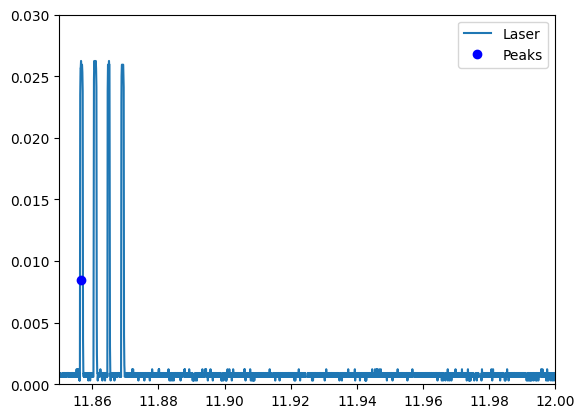

In [117]:
print(len(t_on))
print(len(laser.peaks)/4)
print(((laser.peaks[4]- laser.peaks[0])/2e4)*1000)
plt.plot(laser.time_vec ,laser.stim_ch, label='laser')
plt.plot(laser.peaks[0]/2e4,[laser.peak_height-0.0015],'o',c = 'blue', label='peak')
plt.plot(laser.peaks[-4]/2e4,[laser.peak_height-0.0015],'o',c = 'blue', label='peak')
plt.xlim(11.85, 12)
plt.ylim(0, 0.03)
plt.legend(['Laser','Peaks'])


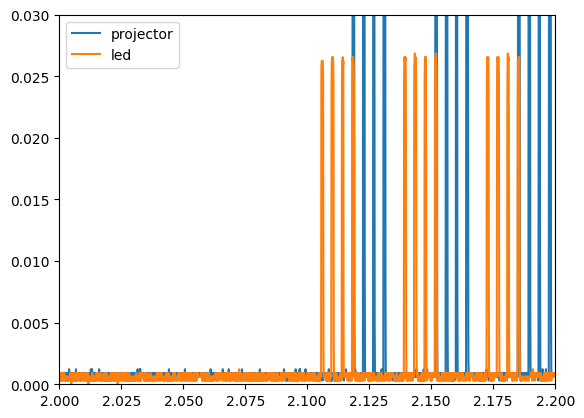

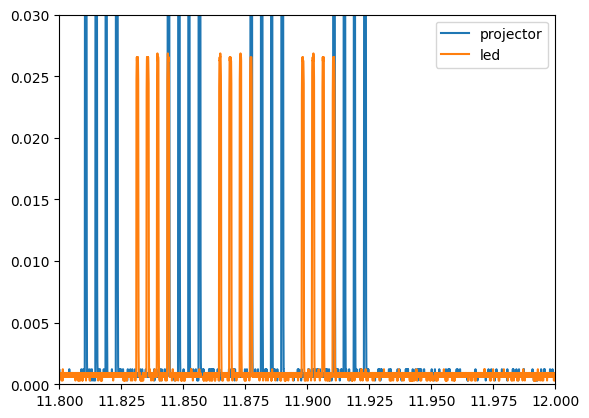

In [5]:
from Neitz import Neitz
from pathlib import Path
import matplotlib.pyplot as plt

projector = Neitz(filepath=Path.cwd())
projector.abfread("2026_01_01_0003_p.abf")
projector.stim_ch = (projector.stim_ch)*-1
projector.stim_ch = projector.stim_ch - min(projector.stim_ch)

led = Neitz(filepath=Path.cwd())
led.abfread("2026_01_01_0006_l.abf")
led.stim_ch = (led.stim_ch)*-1
led.stim_ch = led.stim_ch - min(led.stim_ch)

plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([2, 2.2, 0, 0.03])
plt.legend(["projector", "led"])


plt.figure()
plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([11.8, 12, 0, 0.03])
plt.legend(["projector_1", "led_1"])

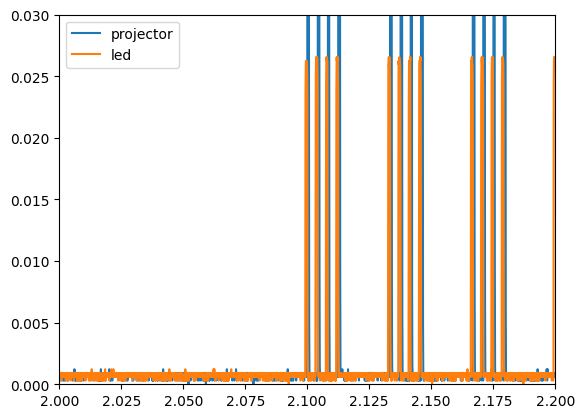

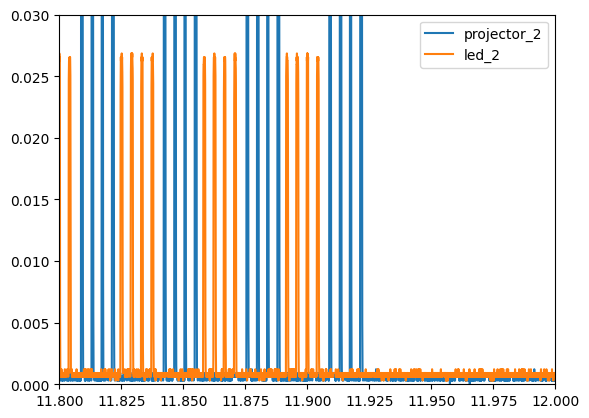

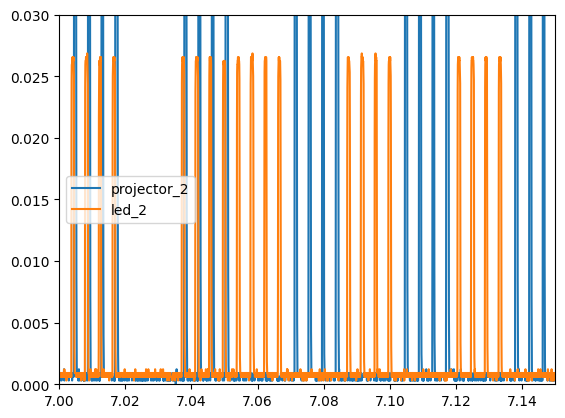

In [21]:
from Neitz import Neitz
from pathlib import Path
import matplotlib.pyplot as plt

projector = Neitz(filepath=Path.cwd())
projector.abfread("2026_01_01_0004_p.abf")
projector.stim_ch = (projector.stim_ch)*-1
projector.stim_ch = projector.stim_ch - min(projector.stim_ch)

led = Neitz(filepath=Path.cwd())
led.abfread("2026_01_01_0007_l.abf")
led.stim_ch = (led.stim_ch)*-1
led.stim_ch = led.stim_ch - min(led.stim_ch)

plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([2, 2.2, 0, 0.03])
plt.legend(["projector", "led"])


plt.figure()
plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([11.8, 12, 0, 0.03])
plt.legend(["projector_2", "led_2"])


plt.figure()
plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([7, 7.15, 0, 0.03])
plt.legend(["projector_2", "led_2"])

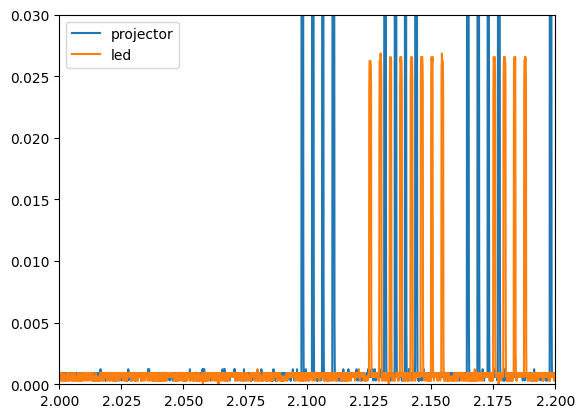

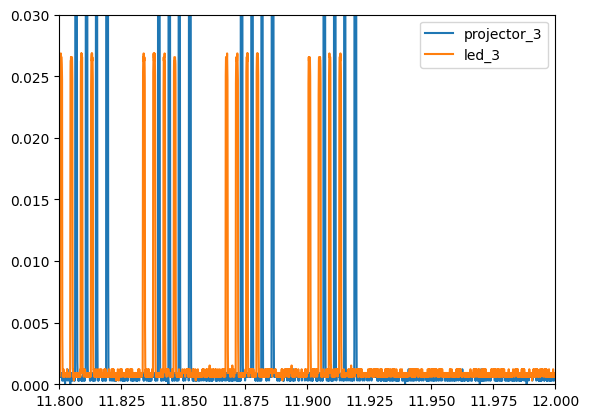

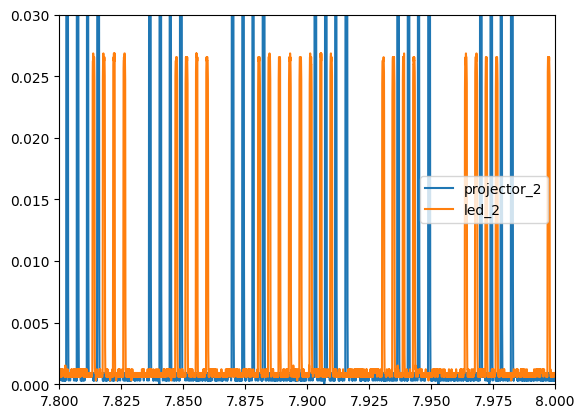

In [26]:
from Neitz import Neitz
from pathlib import Path
import matplotlib.pyplot as plt

projector = Neitz(filepath=Path.cwd())
projector.abfread("2026_01_01_0005_p.abf")
projector.stim_ch = (projector.stim_ch)*-1
projector.stim_ch = projector.stim_ch - min(projector.stim_ch)

led = Neitz(filepath=Path.cwd())
led.abfread("2026_01_01_0008_l.abf")
led.stim_ch = (led.stim_ch)*-1
led.stim_ch = led.stim_ch - min(led.stim_ch)

plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([2, 2.2, 0, 0.03])
plt.legend(["projector", "led"])


plt.figure()
plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([11.8, 12, 0, 0.03])
plt.legend(["projector_3", "led_3"])

plt.figure()
plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(led.time_vec ,led.stim_ch)
plt.axis([7.8, 8, 0, 0.03])
plt.legend(["projector_2", "led_2"])

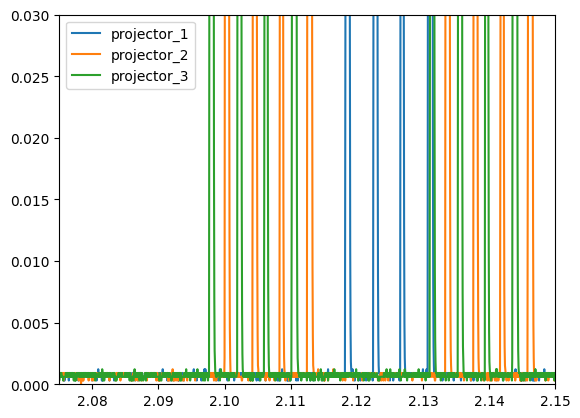

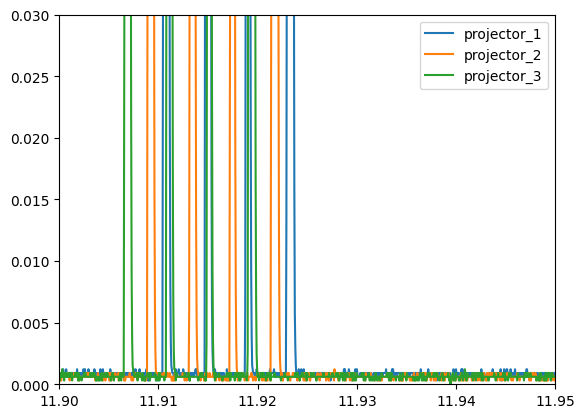

In [8]:
from Neitz import Neitz
from pathlib import Path
import matplotlib.pyplot as plt

projector = Neitz(filepath=Path.cwd())
projector.abfread("2026_01_01_0003_p.abf")
projector.stim_ch = (projector.stim_ch)*-1
projector.stim_ch = projector.stim_ch - min(projector.stim_ch)

projector1 = Neitz(filepath=Path.cwd())
projector1.abfread("2026_01_01_0004_p.abf")
projector1.stim_ch = (projector1.stim_ch)*-1
projector1.stim_ch = projector1.stim_ch - min(projector1.stim_ch)

projector2 = Neitz(filepath=Path.cwd())
projector2.abfread("2026_01_01_0005_p.abf")
projector2.stim_ch = (projector2.stim_ch)*-1
projector2.stim_ch = projector2.stim_ch - min(projector2.stim_ch)

plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(projector1.time_vec ,projector1.stim_ch)
plt.plot(projector2.time_vec ,projector2.stim_ch)
plt.axis([2.075, 2.15, 0, 0.03])
plt.legend(["projector_1", "projector_2", "projector_3"])


plt.figure()
plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(projector1.time_vec ,projector1.stim_ch)
plt.plot(projector2.time_vec ,projector2.stim_ch)
plt.axis([11.9, 11.95, 0, 0.03])
plt.legend(["projector_1", "projector_2", "projector_3"])

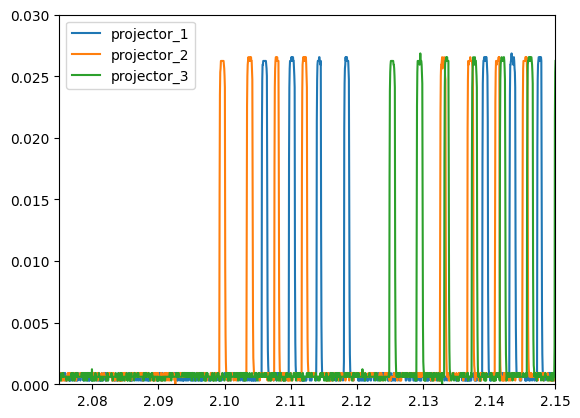

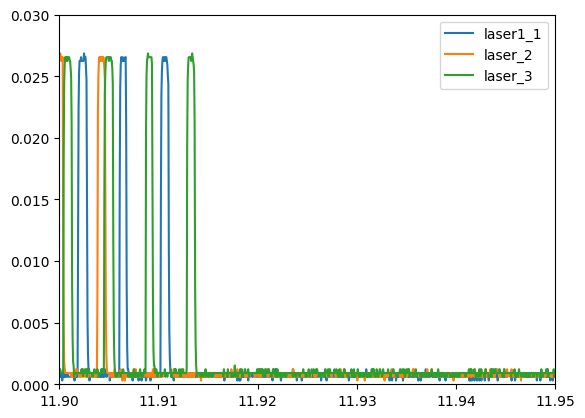

In [10]:
from Neitz import Neitz
from pathlib import Path
import matplotlib.pyplot as plt

projector = Neitz(filepath=Path.cwd())
projector.abfread("2026_01_01_0006_l.abf")
projector.stim_ch = (projector.stim_ch)*-1
projector.stim_ch = projector.stim_ch - min(projector.stim_ch)

projector1 = Neitz(filepath=Path.cwd())
projector1.abfread("2026_01_01_0007_l.abf")
projector1.stim_ch = (projector1.stim_ch)*-1
projector1.stim_ch = projector1.stim_ch - min(projector1.stim_ch)

projector2 = Neitz(filepath=Path.cwd())
projector2.abfread("2026_01_01_0008_l.abf")
projector2.stim_ch = (projector2.stim_ch)*-1
projector2.stim_ch = projector2.stim_ch - min(projector2.stim_ch)

plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(projector1.time_vec ,projector1.stim_ch)
plt.plot(projector2.time_vec ,projector2.stim_ch)
plt.axis([2.075, 2.15, 0, 0.03])
plt.legend(["projector_1", "projector_2", "projector_3"])


plt.figure()
plt.plot(projector.time_vec ,projector.stim_ch)
plt.plot(projector1.time_vec ,projector1.stim_ch)
plt.plot(projector2.time_vec ,projector2.stim_ch)
plt.axis([11.9, 11.95, 0, 0.03])
plt.legend(["laser1_1", "laser_2", "laser_3"])

Delays (s): [-0.0002 -0.0003 -0.0003 ... -0.0004 -0.0003 -0.0003]
mean delay (ms): -0.29516985138004354 std (ms): 0.05211068189434855
Projector IPI (ms): [4.25 4.1  4.15 ... 4.25 4.1  4.15]
LED IPI (ms): [4.15 4.15 4.15 ... 4.15 4.15 4.15]


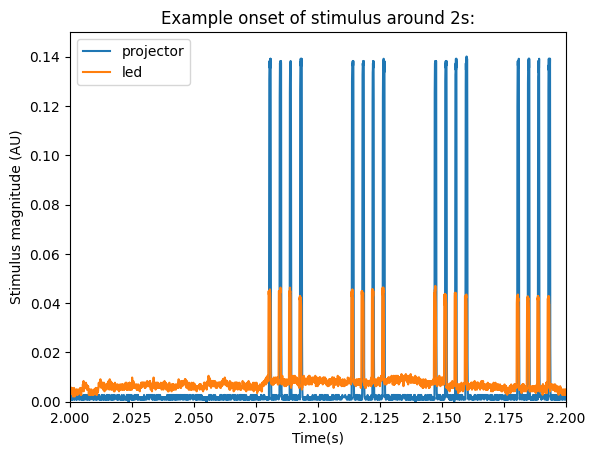

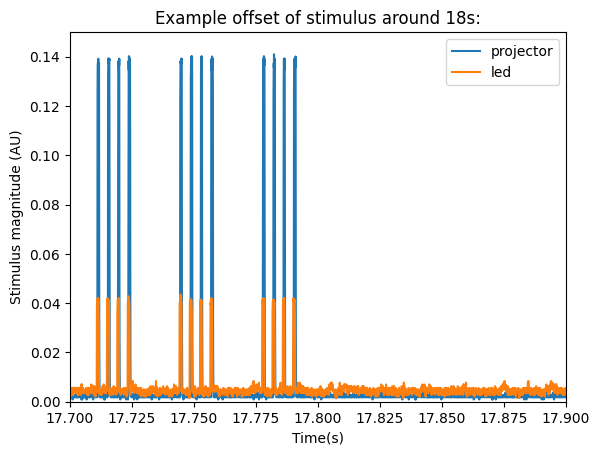

In [12]:
import pyabf 
import matplotlib.pyplot as plt

abf = pyabf.ABF("data/2026_01_12_0003.abf")  # load the file
abf.setSweep(0,channel= 2)  # Channel 0 is recording channel
stim_ch = abf.sweepY.copy()
time_vec = abf.sweepX.copy()
stim_ch_m = min(stim_ch)
stim_ch = (stim_ch-stim_ch_m)/max(stim_ch)


abf.setSweep(0,channel= 3)  # Channel 2 is Stim channel
led_ch = abf.sweepY.copy()
led_ch_m = min(led_ch)
led_ch = (led_ch-led_ch_m)/max(led_ch)



plt.plot(time_vec ,stim_ch)
plt.plot(time_vec ,led_ch)
plt.axis([2., 2.2, 0, 0.15])
plt.legend(["projector", "led"])
plt.xlabel("Time(s)")
plt.ylabel("Stimulus magnitude (AU)")
plt.title("Example onset of stimulus around 2s​:")

plt.figure()
plt.plot(time_vec ,stim_ch)
plt.plot(time_vec ,led_ch)
plt.axis([17.7, 17.9, 0, 0.15])
plt.legend(["projector", "led"])
plt.xlabel("Time(s)")
plt.ylabel("Stimulus magnitude (AU)")
plt.title("Example offset of stimulus around 18s​:")

import numpy as np
from scipy.signal import find_peaks

def peak_onsets(time_vec, y, *, prominence=0.02, peak_height=None, frac=0.2, min_distance_s=None):
    """
    Find peak indices with find_peaks, then define each peak's onset as the last sample
    BEFORE the rising edge crosses: baseline + frac*(peak - baseline).
    """
    y = np.asarray(y)
    t = np.asarray(time_vec)

    dt = float(np.median(np.diff(t)))
    distance = None if min_distance_s is None else int(round(min_distance_s / dt))

    peaks, props = find_peaks(y, prominence=prominence, height=peak_height, distance=distance)

    # robust baseline (low percentile)
    baseline = np.percentile(y, 5)

    onset_idx = []
    for p in peaks:
        thresh = baseline + frac * (y[p] - baseline)

        i = p
        # walk left until we drop below threshold
        while i > 0 and y[i] >= thresh:
            i -= 1
        onset_idx.append(i)

    onset_idx = np.array(onset_idx, dtype=int)
    onset_t = t[onset_idx]
    return peaks, onset_idx, onset_t, props

# --- use your existing stim_ch, led_ch, time_vec ---
# (optional) better normalization if you want:
# stim_ch = (stim_ch - stim_ch.min()) / (stim_ch.max() - stim_ch.min() + 1e-12)
# led_ch  = (led_ch  - led_ch.min())  / (led_ch.max()  - led_ch.min()  + 1e-12)

proj_peaks, proj_on_idx, proj_on_t, _ = peak_onsets(
    time_vec, stim_ch, prominence=0.01, frac=0.2, min_distance_s=0.001
)
led_peaks, led_on_idx, led_on_t, _ = peak_onsets(
    time_vec, led_ch,  prominence=0.01, frac=0.2, min_distance_s=0.001
)

# 1) onset-to-onset delay (LED minus projector), aligned by order
n = min(len(proj_on_t), len(led_on_t))
delay = led_on_t[:n] - proj_on_t[:n]

print("Delays (s):", delay)
print("mean delay (ms):", 1e3*np.mean(delay), "std (ms):", 1e3*np.std(delay))

# 2) within-channel onset spacing (inter-pulse intervals)
print("Projector IPI (ms):", 1e3*np.diff(proj_on_t))
print("LED IPI (ms):",       1e3*np.diff(led_on_t))


Text(0.5, 1.0, 'Example frame skip/lag consistency')

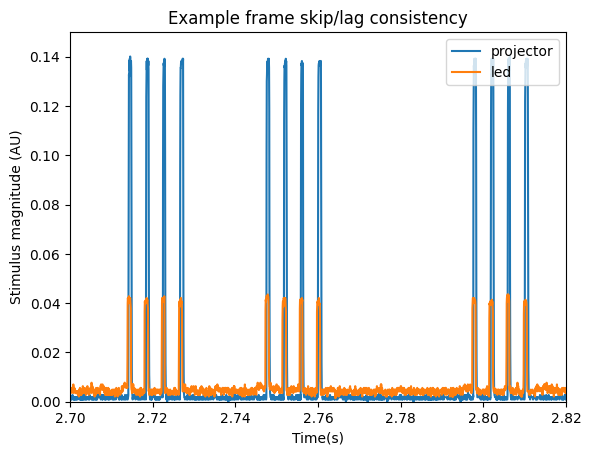

In [72]:
plt.figure()
plt.plot(time_vec ,stim_ch)
plt.plot(time_vec ,led_ch)
plt.axis([2.7, 2.82, 0, 0.15])
plt.legend(["projector", "led"], loc='upper right')
plt.xlabel("Time(s)")
plt.ylabel("Stimulus magnitude (AU)")
plt.title("Example frame skip/lag consistency")


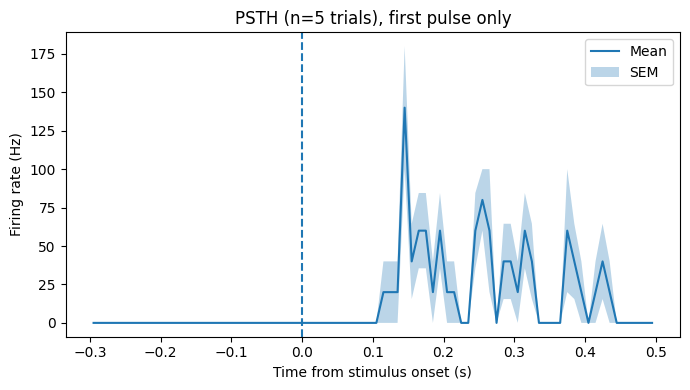

In [9]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from Neitz import Neitz  # your renamed module

# -----------------------
# File selection (e.g., 07–11)
# -----------------------
START_NUM = 7
END_NUM   = 11  # inclusive
DATE_STR  = "2026_01_14"

files = [Path.cwd() / "data" / f"{DATE_STR}_{n:04d}.abf" for n in range(START_NUM, END_NUM + 1)]
missing = [str(f) for f in files if not f.exists()]
if missing:
    raise FileNotFoundError("Missing ABF files:\n" + "\n".join(missing))

# -----------------------
# PSTH params
# -----------------------
PRE_S = 0.3
POST_S = 0.5
BIN_S = 0.01  # 10 ms bins
LATENCY_S = -0.00295  # your calibrated delay (seconds). positive => actual stimulus later than projector peak/onset

# Stim peak/onset detection params (tune to your projector trace)
STIM_PROM = 0.001      # prominence in stim units
STIM_HEIGHT = None     # or set e.g. 0.005
ONSET_FRAC = 0.2       # onset at 20% of peak above baseline (walking left)

# -----------------------
# Helper: first stim onset from projector trace (first pulse only)
# -----------------------
def train_start_onset(time_vec, stim_ch, stim_threshold, quiet_before_s=0.2):
    """
    Returns t_on = first rising edge that occurs AFTER at least quiet_before_s
    of continuous stim OFF (below threshold). Good for 60 Hz flicker trains.
    """
    t = np.asarray(time_vec)
    y = np.asarray(stim_ch)

    stim_on = y > stim_threshold
    edges = np.diff(stim_on.astype(int))
    rise_idx = np.where(edges == 1)[0] + 1
    if len(rise_idx) == 0:
        raise RuntimeError("No rising edges found. Tune stim_threshold.")

    dt = float(np.median(np.diff(t)))
    quiet_n = int(round(quiet_before_s / dt))

    for r in rise_idx:
        left = max(0, r - quiet_n)
        if not np.any(stim_on[left:r]):  # all OFF for quiet_before_s
            return float(t[r])

    # fallback: just return first rise
    return float(t[rise_idx[0]])

# -----------------------
# Build per-trial PSTHs (rates), aligned to first stim onset
# -----------------------
edges = np.arange(-PRE_S, POST_S + BIN_S, BIN_S)
centers = (edges[:-1] + edges[1:]) / 2

trial_rates = []  # shape: (n_trials, n_bins)

projector = Neitz(filepath=Path.cwd(), spike_ch_num=0, stim_ch_num=2,
                  peak_height=20.0, stim_threshold=.03)

for f in files:
    projector.abfread(f.name)

    # spikes
    peak_idx = projector.find_spikes()
    spike_t = projector.time_vec[peak_idx]

    # first stim onset (projector trace shape like your plot)
    t_on = train_start_onset(projector.time_vec, projector.stim_ch,
                         stim_threshold=projector.stim_threshold,
                         quiet_before_s=0.2) + LATENCY_S

    t_on = t_on + LATENCY_S

    # align spikes to onset and make PSTH
    rel = spike_t - t_on
    counts, _ = np.histogram(rel, bins=edges)
    rates = counts / BIN_S  # Hz
    trial_rates.append(rates)

trial_rates = np.asarray(trial_rates)  # (n_trials, n_bins)

mean_rate = trial_rates.mean(axis=0)
sem_rate = trial_rates.std(axis=0, ddof=1) / np.sqrt(trial_rates.shape[0])

# -----------------------
# Plot mean ± SEM PSTH
# -----------------------
plt.figure(figsize=(7, 4))
plt.plot(centers, mean_rate, label="Mean")
plt.fill_between(centers, mean_rate - sem_rate, mean_rate + sem_rate, alpha=0.3, label="SEM")
plt.axvline(0, linestyle="--")
plt.xlabel("Time from stimulus onset (s)")
plt.ylabel("Firing rate (Hz)")
plt.title(f"PSTH (n={trial_rates.shape[0]} trials), first pulse only")
plt.legend()
plt.tight_layout()
plt.show()


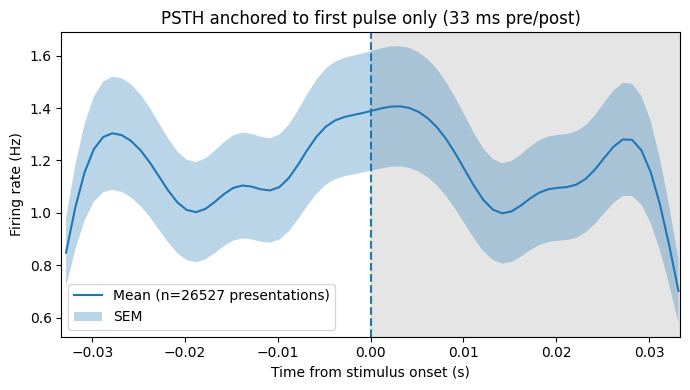

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from pathlib import Path
from Neitz import Neitz

# -----------------------
# FIXED windows for 30 Hz cycle (OFF+ON = 1/30 s)
# -----------------------
PRE_S  = 1/30   # 0.033333...
POST_S = 1/30   # 0.033333...
BIN_S  = 0.001  # 1 ms bins (fine for 33 ms window)

LATENCY_S = 0.0  # your calibrated delay

# -----------------------
# Detection / presentation params
# -----------------------
DATE_STR = "2026_01_14"
START_NUM, END_NUM = 7, 11
REC_CH, STIM_CH = 0, 2

STIM_PROM = 0.001
STIM_HEIGHT = None
ONSET_FRAC = 0.2

PULSES_PER_PRESENTATION = 4  # anchor to first pulse, ignore next 3

SMOOTH_SIGMA_S = 0.003  # 3 ms smoothing (optional)

# -----------------------
# Helpers
# -----------------------
def gaussian_smooth(y, bin_s, sigma_s=0.003):
    sigma_bins = max(1, int(round(sigma_s / bin_s)))
    half = 4 * sigma_bins
    x = np.arange(-half, half + 1)
    k = np.exp(-(x**2) / (2 * sigma_bins**2))
    k /= k.sum()
    return np.convolve(y, k, mode="same")

def pulse_onsets_from_peaks(t, stim, prom=None, height=None, onset_frac=0.2):
    t = np.asarray(t); y = np.asarray(stim)
    peaks, _ = find_peaks(y, prominence=prom, height=height)
    if len(peaks) == 0:
        return np.array([])

    baseline = np.percentile(y, 5)
    onsets = []
    for p in peaks:
        thresh = baseline + onset_frac * (y[p] - baseline)
        i = int(p)
        while i > 0 and y[i] >= thresh:
            i -= 1
        onsets.append(t[i])
    return np.asarray(onsets)

def nansem(a, axis=0):
    n = np.sum(~np.isnan(a), axis=axis)
    sd = np.nanstd(a, axis=axis, ddof=1)
    return sd / np.sqrt(n)

# -----------------------
# Files
# -----------------------
files = [Path.cwd() / "data" / f"{DATE_STR}_{n:04d}.abf" for n in range(START_NUM, END_NUM + 1)]
missing = [str(f) for f in files if not f.exists()]
if missing:
    raise FileNotFoundError("Missing ABF files:\n" + "\n".join(missing))

# -----------------------
# PSTH across all presentations (defined as every 4th pulse)
# -----------------------
edges = np.arange(-PRE_S, POST_S + BIN_S, BIN_S)
centers = (edges[:-1] + edges[1:]) / 2

event_rates = []

projector = Neitz(filepath=Path.cwd(), spike_ch_num=REC_CH, stim_ch_num=STIM_CH,
                  peak_height=20.0, stim_threshold=1.0)

for f in files:
    projector.abfread(f.name)
    spike_idx = projector.find_spikes()
    spike_t = projector.time_vec[spike_idx]

    pulse_on = pulse_onsets_from_peaks(projector.time_vec, projector.stim_ch,
                                       prom=STIM_PROM, height=STIM_HEIGHT, onset_frac=ONSET_FRAC)
    if len(pulse_on) == 0:
        continue

    pulse_on = np.sort(pulse_on)

    # presentation onsets: take 0,4,8,... (anchor to first pulse, ignore next 3)
    pres_on = pulse_on[::PULSES_PER_PRESENTATION] + LATENCY_S

    for t0 in pres_on:
        rel = spike_t - t0
        counts, _ = np.histogram(rel, bins=edges)
        rates = counts / BIN_S  # Hz
        event_rates.append(rates)

event_rates = np.asarray(event_rates)
if event_rates.size == 0:
    raise RuntimeError("No presentations detected. Tune STIM_PROM/STIM_HEIGHT.")

mean_rate = np.mean(event_rates, axis=0)
sem_rate  = np.std(event_rates, axis=0, ddof=1) / np.sqrt(event_rates.shape[0])

# smooth (optional)
mean_sm = gaussian_smooth(mean_rate, BIN_S, sigma_s=SMOOTH_SIGMA_S)
sem_sm  = gaussian_smooth(sem_rate,  BIN_S, sigma_s=SMOOTH_SIGMA_S)

# -----------------------
# Plot with single grey box representing ONE cycle (ON+OFF = 1/30 s)
# -----------------------
plt.figure(figsize=(7,4))

# show one cycle window as a single box (0 to POST_S)
plt.axvspan(0, POST_S, alpha=0.2, color="grey")

plt.plot(centers, mean_sm, label=f"Mean (n={event_rates.shape[0]} presentations)")
plt.fill_between(centers, mean_sm - sem_sm, mean_sm + sem_sm, alpha=0.3, label="SEM")
plt.axvline(0, linestyle="--")

plt.xlim(-PRE_S, POST_S)
plt.xlabel("Time from stimulus onset (s)")
plt.ylabel("Firing rate (Hz)")
plt.title("PSTH anchored to first pulse only (33 ms pre/post)")
plt.legend()
plt.tight_layout()
plt.show()
